<a href="https://www.kaggle.com/code/ondrejmajor/rohlik-orders-prediction-lstm-w-result-plots?scriptVersionId=190299422" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rohlík Data Preprocessing
This notebook contains a time series forecasting task on Rohlik dataset. EDA, data preprocessing and forecasting engine is LSTM model with Tensorflow 2 backend. 

<br><b>Approach:</b>
<br>As Rohlík orders dataset contains data from multiple warehouses, thus it contains multiple timelines, the approach is to process and predict each warehouse as a separate timeline. The preprocessing, fitting and evaluation steps are the same for each warehouse. Very wide and shallow LSTM neural net (above 256 units) is used to process the feature rich dataset. Batch size is kept low enough (around 32) to keep the weekly spikes in target sharp.

<br>This approach yields very good MAPE value, which is calculated as a mean of all warehouse timeline results.

<b>This notebook is written with end-to-end mindset as if the models are to be deployed. Models, scalers and training configurations are saved. The test dataset is predicted on with inference style. The predictions can be done offline without the trainig notebook.

In [1]:
#! pip -q install pandas matplotlib numpy seaborn 
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Reshape, LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input, LayerNormalization, Conv1D, Concatenate, MaxPooling1D, MultiHeadAttention, GlobalAveragePooling1D, Activation, SpatialDropout1D, Lambda
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from scipy import interpolate
from sklearn.model_selection import KFold

TIME_STEPS = 1
EPOCHS = 100
BATCH_SIZE = 
LEARNING_RATE = 1e-3

# NUM_FOLDS = 5 # Not implemented

OFF_DAYS = False # Experimental. Fill missing days in timeseries as "offday" and fill features and target with 0s. 
LAG = True # add lag and rolling features
FILL = True # fill nan with zeros before training
SCALER = "standard" # standard best by far...

#WAREHOUSE = ["Prague_1", "Prague_2", "Prague_3"] # Train only particular warehouse timelines (For testing purposes)
WAREHOUSE = [None]  # Train on all warehouses (whole dataset)


# Temporal features
#LAG_DAYS = [1, 7, 28, 56, 168, 364]  # more mainstream values
#ROLLING_WINDOW = [7, 28, 168, 364]  # more mainstream values
LAG_DAYS = [63, 119, 168, 364]  # this lag bridges the whole test dataset with past data
ROLLING_WINDOW = [63, 168, 364]  # this lag bridges the whole test dataset with past data


pd.set_option('display.max_columns', None)  # see all columns in pandas

train_df_raw = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train.csv")
train_calendar_df_raw = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv")
test_df_raw = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/test.csv")
test_calendar_df_raw = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

2024-07-29 13:24:01.856952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:24:01.857107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:24:02.012596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Optional - Dataset Validation

Evaluate the correctness of the data from multiple sources. Check both .csvs if their values in the overlapping columns match and then merge them into one dataset.
<br>After that we get train_df and test_df dataframes.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nAll values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'mov_change', 'holiday_name', 'school_holidays', 'snow', 'holiday', 'blackout', 'shutdown', 'shops_closed', 'mini_shutdown', 'precipitation', 'winter_school_holidays', 'frankfurt_shutdown', 'date', 'warehouse'}
No differences found in column: mov_change
No differences found in column: holiday_name
No differences found in column: school_holidays
No differences found in column: snow
No differences found in column: holiday
No differences found in column: blackout
No differences found in column: shutdown
No differences found in column: shops_closed
No differences found in column: mini_shutdown
No differences found in column: precipitation
No differences found in column: winter_school_holidays
No differences found in column: frankfurt_shutdown

All values match across the datasets, datasets merged.
{'holiday_name', 'school_holidays', 'holiday', 'shops_closed', 'winter_school_holidays', 'date', 'warehouse'}
No differences found in column: holiday_name
No differences found in column: school_

In [5]:
# Sort the datasets by 'date' and 'warehouse' ascendingly

train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

## Drop unnecesary data
There are some features in the training set that are not availiable in the testing set, so we do not use them.
<br>The "orders" column we keep as it is our target.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['mov_change', 'warehouse_limited', 'snow', 'blackout', 'shutdown', 'user_activity_1', 'precipitation', 'mini_shutdown', 'frankfurt_shutdown', 'user_activity_2']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

Columns that have unchanging values or very little movement, sometimes redundant features.
<br> We look as binary features that might be alway 0 or 1.
<br> "school_holidays" and "shops_closed" are redundant in some warehouses
<br> We can drop these columns as they are redundant but in this run we leave it.

In [8]:
# Run the code to identify and drop unchanging columns

for warehouse in train_df['warehouse'].unique():
    unchanging_columns = []
    print(f"\nWarehouse: {warehouse}")
    for feature in train_df.columns:
        if feature in ['warehouse', 'date']:
            continue

        values = train_df[train_df['warehouse'] == warehouse][feature].nunique()
        if values == 1:
            print(f"Feature {feature} has {values} unique values")
            print(f"Value: {train_df[train_df['warehouse'] == warehouse][feature].unique()}")
            if feature not in unchanging_columns:
                unchanging_columns.append(feature)
        if values == 2:
            print(f"Feature {feature} has {values} unique values")
            true_count = sum(train_df[train_df['warehouse'] == warehouse][feature] == 1)
            total_count = len(train_df[train_df['warehouse'] == warehouse])
            print(f"{true_count} items True of {total_count}")

    print(f"    Unchanging columns in {warehouse}: {unchanging_columns}")



Warehouse: Brno_1
Feature holiday has 2 unique values
45 items True of 1193
Feature shops_closed has 2 unique values
20 items True of 1193
Feature winter_school_holidays has 2 unique values
28 items True of 1193
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Brno_1: ['school_holidays']

Warehouse: Budapest_1
Feature holiday has 2 unique values
9 items True of 1154
Feature shops_closed has 1 unique values
Value: [0]
Feature winter_school_holidays has 2 unique values
6 items True of 1154
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Budapest_1: ['shops_closed', 'school_holidays']

Warehouse: Prague_1
Feature holiday has 2 unique values
45 items True of 1193
Feature shops_closed has 2 unique values
20 items True of 1193
Feature winter_school_holidays has 2 unique values
84 items True of 1193
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Prague_1: ['school_holidays']

Warehouse: Prague_

In [9]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


## Experimental - Line-up all warehouse timelines in the same time format.
This is experimental function with a purpose:

-   When we examine the dataset, we can see that some warehouses do not operate at sundays. 
-   Some warehouses are missing a lot of days rom first months as they were just setting up oin new markets.
-   There are missing days on other warehouses sometimes.
-   <b>This function introduces</b> a new feature <b>"off_day"</b>, which is 1 whenever we have missing day in the dataset.
- Currently diabled, uncomment last line bellow to experiment.

In [10]:
def process_warehouses(train_df, handle_off_days='interpolate'):
    """
    Process each warehouse and handle off days based on the specified method.
    
    Parameters:
    train_df (DataFrame): The input DataFrame containing warehouse data.
    handle_off_days (str): The method to handle off days, either 'interpolate' or 'zeros'.
    
    Returns:
    DataFrame: The processed DataFrame with all warehouses combined.
    """
    combined_df_list = []
    start_dates_info = []

    for warehouse in train_df['warehouse'].unique():
        wh = train_df[train_df['warehouse'] == warehouse]
        
        # Fix specific warehouses with unconisitent data at the start
        if warehouse == 'Frankfurt_1':
            first_month_end = wh['date'].min() + pd.DateOffset(days=4)
            wh = wh[wh['date'] > first_month_end]
        if warehouse == 'Munich_1':
            first_month_end = wh['date'].min() + pd.DateOffset(weeks=5)
            wh = wh[wh['date'] > first_month_end]
            
        wh.set_index('date', inplace=True)
        date_range = pd.date_range(start=wh.index.min(), end=wh.index.max(), freq='D')
        wh_reindexed = wh.reindex(date_range).reset_index()
        wh_reindexed.rename(columns={'index': 'date'}, inplace=True)
        
        # Add off_day column
        wh_reindexed['off_day'] = wh_reindexed['orders'].isna().astype(int)
        
        # Here we have to fill in the missing features for the off days, mostly 0s here, we do not count holidays, etc. for missing days for now.
        wh_reindexed['warehouse'] = warehouse
        wh_reindexed['holiday_name'] = wh_reindexed['holiday_name'].fillna('')
        wh_reindexed['holiday'] = wh_reindexed['holiday'].fillna(0)
        wh_reindexed['shops_closed'] = wh_reindexed['shops_closed'].fillna(0)
        wh_reindexed['winter_school_holidays'] = wh_reindexed['winter_school_holidays'].fillna(0)
        wh_reindexed['school_holidays'] = wh_reindexed['school_holidays'].fillna(0)
        
        if handle_off_days == 'interpolate':
            wh_reindexed['orders'] = wh_reindexed['orders'].interpolate(method='linear')
        elif handle_off_days == 'zeros':
            wh_reindexed['orders'] = wh_reindexed['orders'].fillna(0.0)
        
        # the 'id' column is for the test dataset mostly
        wh_reindexed['id'] = wh_reindexed.apply(lambda row: f"{row['warehouse']}_{row['date'].strftime('%Y-%m-%d')}", axis=1)
        wh_reindexed['day_of_week'] = wh_reindexed['date'].dt.dayofweek + 1  # Monday=1, Sunday=7
        
        # Cut off data to start on the earliest Monday - all warehouses start on timeline on Monday, so they hawe weekly overlap.
        start_date = wh_reindexed['date'].min()
        end_date = wh_reindexed['date'].max()
        start_monday = start_date - pd.Timedelta(days=start_date.weekday())
        end_sunday = end_date + pd.Timedelta(days=(6 - end_date.weekday()))
        wh_reindexed = wh_reindexed[(wh_reindexed['date'] >= start_monday) & (wh_reindexed['date'] <= end_sunday)]
        
        # get info about the start date 
        start_dates_info.append(f"{warehouse}: Start Date: {start_monday.strftime('%Y-%m-%d')} (Day {start_monday.weekday() + 1})")

        # get all new dataframes into a list
        combined_df_list.append(wh_reindexed)
        
        # Plot
        plt.figure(figsize=(20, 10))
        plt.plot(wh_reindexed['date'], wh_reindexed['orders'], marker='x', linestyle='-', markersize=3, linewidth=0.5, label='Orders')

        # start of the first week and end of the last week
        plt.axvline(x=start_monday, color='r', linestyle='--', linewidth=0.5, label='Start of first week')
        plt.axvline(x=end_sunday, color='g', linestyle='--', linewidth=0.5, label='End of last week')
        
        # Highlight the off days
        off_days = wh_reindexed[wh_reindexed['off_day'] == 1]
        plt.scatter(off_days['date'], off_days['orders'], color='red', s=15, label='Off days', marker='o')
        
        # Mark the weekdays on off days
        for idx, row in wh_reindexed.iterrows():
            if row['off_day'] == 1:
                plt.text(row['date'], row['orders'], str(row['day_of_week']), color='black', ha='center', va='bottom', fontsize=10)

        plt.title(f"Volume for warehouse {warehouse}")
        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        # Drop day_of_week column , we will be adding it later as a feature
        wh_reindexed.drop(columns=['day_of_week'], inplace=True)

    # Print start dates for each warehouse
    print("Start Dates for Each Warehouse:")
    for info in start_dates_info:
        print(info)

    # Combine all warehouses into one DataFrame
    train_df_reindexed = pd.concat(combined_df_list, ignore_index=True)
    
    return train_df_reindexed

# Uncomment to use this function
if OFF_DAYS:
    train_df = process_warehouses(train_df, handle_off_days='zeros') # zero or interpolate - zero makes more sense but still confuses the model durin training. Interpolate is purely experimental.

We are merging train and test datasets and process it as one dataset, so we can apply temporal features on both datasets. We will get lag days on the test dataset. Later we split dataset back to train and test for training and prediction.

In [11]:
# merge the two datasets
train_df = pd.concat([train_df, test_df], axis=0)

In our test dataset is not a lot of holidays that had inpact on "orders" in previous years so we are not going to use it. 
<br>It could be used with one-hot encoding and a bit experimentuing.

In [12]:
train_df = train_df.drop(columns=['holiday_name'])

In [13]:
train_df = train_df.sort_values(by=['date', 'warehouse'], ignore_index=True)

In [14]:
train_df.head(7)

warehouse       date  orders  holiday  shops_closed  \
0      Brno_1 2020-12-05  6447.0        0             0   
1  Budapest_1 2020-12-05  4623.0        0             0   
2    Prague_1 2020-12-05  6895.0        0             0   
3    Prague_2 2020-12-05  4154.0        0             0   
4    Prague_3 2020-12-05  4091.0        0             0   
5      Brno_1 2020-12-06  5338.0        0             0   
6  Budapest_1 2020-12-06  4197.0        0             0   

   winter_school_holidays  school_holidays                     id  
0                       0                0      Brno_1_2020-12-05  
1                       0                0  Budapest_1_2020-12-05  
2                       0                0    Prague_1_2020-12-05  
3                       0                0    Prague_2_2020-12-05  
4                       0                0    Prague_3_2020-12-05  
5                       0                0      Brno_1_2020-12-06  
6                       0                0  Budapest_1_2020-12-06

In [15]:
# only get data of one warehouse for the dataset - for testing purposes
if WAREHOUSE != [None]:
    train_df = train_df[train_df['warehouse'].isin(WAREHOUSE)]
    print("ran")

## Produce date features
This function processes the date column and produces multiple time features from it.

In [16]:
from math import pi
def process_date(df):
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract date-related features
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    
    # Calculate days since the start date
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    
    # Create cyclic features
    def cyclical_encode(df, col, max_val):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    
    cyclical_encode(df, 'month', 12)
    cyclical_encode(df, 'day_of_week', 7)
    cyclical_encode(df, 'day_of_year', 365)
    cyclical_encode(df, 'day', 30)

    cat_features = ['day_of_week', 'quarter', 'month', 'day', 'year']
    bin_features = ['is_weekend']
    return df, cat_features, bin_features

In [17]:
# apply process_date function and save the categorical and binary features for later use.

train_df, categorical_features, binary_features=process_date(train_df)

if OFF_DAYS:
    binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'off_day']
else:
    binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

We keep track of important parameters and settings during the training phase, as it is good habbit when later deploying machine learning models for inference.
<br>Here we are tracking features that will be passed through the scalers.

In [18]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders', 'id', 'date'})
print(x_scaler_features)
print(categorical_features)

['day_of_week_cos', 'day_of_week_sin', 'day_of_year_sin', 'day_of_year', 'days_since_start', 'day_cos', 'month_cos', 'day_of_year_cos', 'month_sin', 'day_sin']
['day_of_week', 'quarter', 'month', 'day', 'year']


In [19]:
if "off_day" in binary_features:
    train_df['off_day'] = train_df['off_day'].fillna(0)

    orders = train_df["orders"]
    train_df = train_df.fillna(0)
    train_df["orders"] = orders

In [20]:
# Review dataset before proecssing
train_df.head(7)

warehouse       date  orders  holiday  shops_closed  \
0      Brno_1 2020-12-05  6447.0        0             0   
1  Budapest_1 2020-12-05  4623.0        0             0   
2    Prague_1 2020-12-05  6895.0        0             0   
3    Prague_2 2020-12-05  4154.0        0             0   
4    Prague_3 2020-12-05  4091.0        0             0   
5      Brno_1 2020-12-06  5338.0        0             0   
6  Budapest_1 2020-12-06  4197.0        0             0   

   winter_school_holidays  school_holidays                     id  quarter  \
0                       0                0      Brno_1_2020-12-05        4   
1                       0                0  Budapest_1_2020-12-05        4   
2                       0                0    Prague_1_2020-12-05        4   
3                       0                0    Prague_2_2020-12-05        4   
4                       0                0    Prague_3_2020-12-05        4   
5                       0                0      Brno_1_2020-12-06        4   
6                       0                0  Budapest_1_2020-12-06        4   

   year  month  day  day_of_week  day_of_year  is_weekend  days_since_start  \
0  2020     12    5            5          340           1                 0   
1  2020     12    5            5          340           1                 0   
2  2020     12    5            5          340           1                 0   
3  2020     12    5            5          340           1                 0   
4  2020     12    5            5          340           1                 0   
5  2020     12    6            6          341           1                 1   
6  2020     12    6            6          341           1                 1   

      month_sin  month_cos  day_of_week_sin  day_of_week_cos  day_of_year_sin  \
0 -2.449294e-16        1.0        -0.974928        -0.222521        -0.417194   
1 -2.449294e-16        1.0        -0.974928        -0.222521        -0.417194   
2 -2.449294e-16        1.0        -0.974928        -0.222521        -0.417194   
3 -2.449294e-16        1.0        -0.974928        -0.222521        -0.417194   
4 -2.449294e-16        1.0        -0.974928        -0.222521        -0.417194   
5 -2.449294e-16        1.0        -0.781831         0.623490        -0.401488   
6 -2.449294e-16        1.0        -0.781831         0.623490        -0.401488   

   day_of_year_cos   day_sin   day_cos  
0         0.908818  0.866025  0.500000  
1         0.908818  0.866025  0.500000  
2         0.908818  0.866025  0.500000  
3         0.908818  0.866025  0.500000  
4         0.908818  0.866025  0.500000  
5         0.915864  0.951057  0.309017  
6         0.915864  0.951057  0.309017

## Correlation Matrix

In [21]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

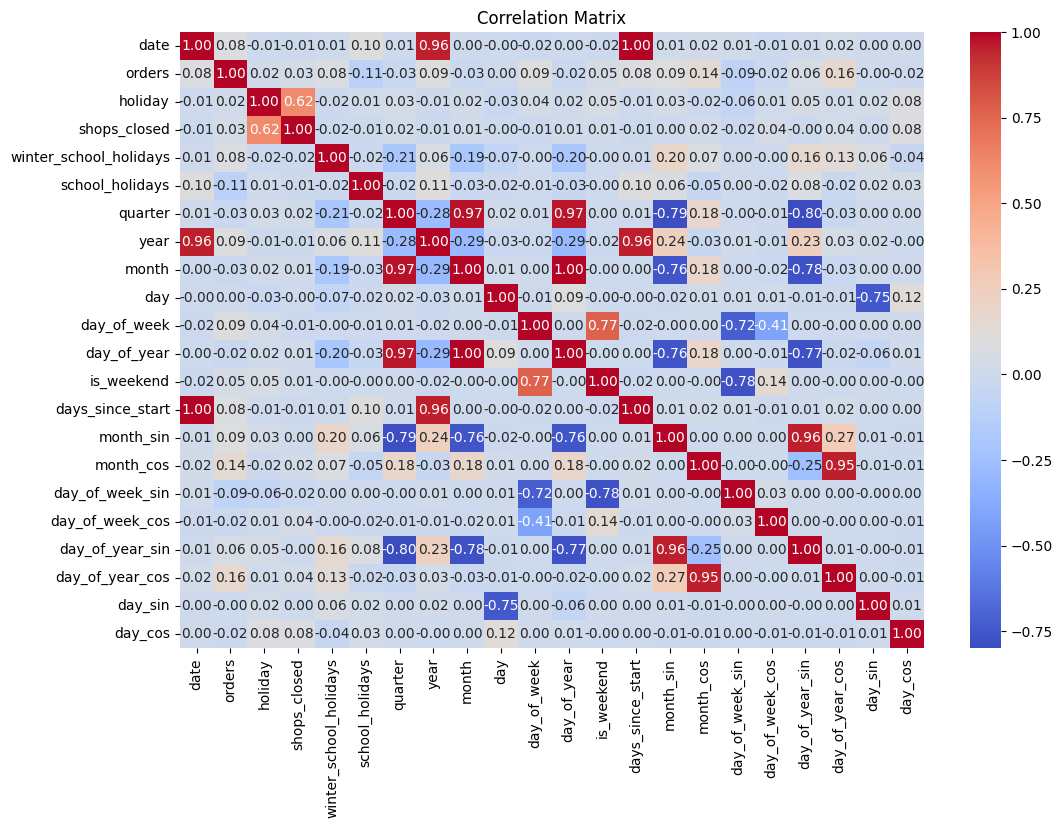

orders                    1.000000
day_of_year_cos           0.163331
month_cos                 0.142166
month_sin                 0.093846
day_of_week               0.086522
year                      0.085920
days_since_start          0.080793
date                      0.080793
winter_school_holidays    0.077211
day_of_year_sin           0.055376
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
day                       0.002689
day_sin                  -0.004039
day_cos                  -0.018817
day_of_week_cos          -0.022768
day_of_year              -0.024332
month                    -0.025271
quarter                  -0.029323
day_of_week_sin          -0.089195
school_holidays          -0.105071
Name: orders, dtype: float64


In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

## Produce temporal features
Create lag and rolling window features.

In [23]:
def create_lag_features(df, col, lag_days):
    df = df.copy()
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df[col].rolling(window, min_periods=1).mean()
        df[std_feature] = df[col].rolling(window, min_periods=1).std()
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [24]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, redundant_features=[], inference=False, fill_method='ffill', lag = True):
    warehouse = df['warehouse'].iloc[0]
    redundant_df = df[redundant_features]
    df = df.drop(columns=redundant_features)
    
    if inference is False and lag is True:
        # Create lag and rolling features
        df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)
        
        x_scaler_features = x_scaler_features + lag_features + window_features
        
        # Handle NaN values in lag and rolling features
        if fill_method == 'ffill':
            df[lag_features + window_features] = df[lag_features + window_features].ffill().bfill()
            orders = df["orders"]
            df = df.ffill().bfill()
            df["orders"] = orders
            
        elif fill_method == 'zero':
            df[lag_features + window_features] = df[lag_features + window_features].fillna(0)
            orders = df["orders"]
            df = df.fillna(0)
            df["orders"] = orders
    
    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, f'onehot_scaler_{warehouse}.joblib')
    else:
        encoder = joblib.load(f'onehot_scaler_{warehouse}.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    # Prepare features for scaling
    if inference is False:
        X = df.drop(columns=['orders'])
        y = df['orders']
    else:
        X = df

    # Initialize and fit/transform scalers
    if not inference:
        if SCALER == "minmax":
            x_scaler = MinMaxScaler(feature_range=(0, 1))
            y_scaler = MinMaxScaler(feature_range=(0, 1))
        elif SCALER == "robust":
            x_scaler = RobustScaler()
            y_scaler = RobustScaler()
        else:
            x_scaler = StandardScaler()
            y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, f'x_scaler_{warehouse}.joblib')
        joblib.dump(y_scaler, f'y_scaler_{warehouse}.joblib')
    else:
        x_scaler = joblib.load(f'x_scaler_{warehouse}.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        #y_scaler = joblib.load(f'y_scaler_{warehouse}.joblib')
        #y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features],  # Binary features (unchanged)
        redundant_df  # Add redundant features back for the test data export
    ], axis=1)
    
    if inference:
        print(final_df.shape)
        return final_df
    else:
        print(final_df.shape, y_scaled.shape)
        return final_df, y_scaled

## Data Preprocessing Function
This is preprocessing function that applies:
<br>lag features
<br>one-hot encoding of categorical features
<br>feature-target split
<br>feature, target scaling
<br>return the final dataframe

## Outliers Reduction Function
Function to fix outliers - orders that are very high or very low. 
<br>Plot the outliers.
<br>Settings of the z-score and window that is outliers calculated with.

In [25]:
if not OFF_DAYS:
    def z_score_outlier_detection(data, window=14, threshold=3):
        data = data.sort_index()
        rolling_mean = data.rolling(window=window, center=True, min_periods=1).mean()
        rolling_std = data.rolling(window=window, center=True, min_periods=1).std()
        z_scores = (data - rolling_mean) / rolling_std
        outliers = (np.abs(z_scores) > threshold) & (data != 0)
        lower_bound = rolling_mean - (threshold * rolling_std)
        upper_bound = rolling_mean + (threshold * rolling_std)
        return outliers, lower_bound, upper_bound


    def weighted_trend_interpolation(data, outliers, window_size=10, weight=0.5):
        fixed_data = data.copy()
        for idx in np.where(outliers)[0]:
            start_idx = max(0, idx - window_size)
            end_idx = min(len(data), idx + window_size + 1)

            prev_values = data.iloc[start_idx:idx].dropna()
            next_values = data.iloc[idx + 1:end_idx].dropna()

            #print(f"Previous values: {prev_values}\n")
            #print(f"Next values: {next_values}\n")

            if len(prev_values) == 0:
                correction = next_values.mean()
            elif len(next_values) == 0:
                correction = prev_values.mean()
            else:
                mean_prev = prev_values.mean()
                mean_next = next_values.mean()

                if mean_next > mean_prev:
                    trend = 'up'
                else:
                    trend = 'down'

                # Calculate new value based on trend and retain some of the original intensity
                if trend == 'up':
                    correction = mean_prev + (next_values.mean() - mean_prev) / 2
                else:
                    correction = mean_prev - (mean_prev - next_values.mean()) / 2

            if np.isnan(correction):  # Handle cases where both prev_values and next_values are NaN
                correction = data.iloc[idx]

            fixed_data.iloc[idx] = weight * data.iloc[idx] + (1 - weight) * correction

            #print(f"Outlier at index {idx}: {data.iloc[idx]} -> {fixed_data.iloc[idx]}")
        return fixed_data


    def plot_outlier_comparison(df, window=28, z_threshold=3, window_size=10, weight=0.5):
        warehouse_data = df['orders']

        z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
        fixed_warehouse_data = weighted_trend_interpolation(warehouse_data, z_outliers, window_size, weight)

        # Plot the original data and outliers
        plt.figure(figsize=(20, 10))
        plt.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
        plt.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
        plt.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='blue', label='Z-Score Outliers', marker='s')

        # Plot fixed outliers
        plt.scatter(warehouse_data.index[z_outliers], fixed_warehouse_data[z_outliers], color='green', label='Fixed Outliers', marker='x')
        plt.title(f'{df["warehouse"].iloc[0]} - Outlier Comparison')
        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"\n{df['warehouse'].iloc[0]}:")
        print(f"Z-Score Outliers: {sum(z_outliers)}")

        # Update the DataFrame with fixed values
        df.loc[:, 'orders'] = fixed_warehouse_data

        return df



else:
    def z_score_outlier_detection(data, window=14, threshold=3):
        # Exclude rows where 'off_day' == 1
        mask = data['off_day'] != 1
        data_filtered = data[mask].copy()
        data_filtered['orders'] = data_filtered['orders'].sort_index()

        rolling_mean = data_filtered['orders'].rolling(window=window, center=True, min_periods=1).mean()
        rolling_std = data_filtered['orders'].rolling(window=window, center=True, min_periods=1).std()
        z_scores = (data_filtered['orders'] - rolling_mean) / rolling_std
        outliers_filtered = (np.abs(z_scores) > threshold) & (data_filtered['orders'] != 0)
        lower_bound_filtered = rolling_mean - (threshold * rolling_std)
        upper_bound_filtered = rolling_mean + (threshold * rolling_std)

        # Create full-length arrays with NaN for excluded indices
        outliers = pd.Series(np.nan, index=data.index)
        lower_bound = pd.Series(np.nan, index=data.index)
        upper_bound = pd.Series(np.nan, index=data.index)

        outliers[mask] = outliers_filtered
        lower_bound[mask] = lower_bound_filtered
        upper_bound[mask] = upper_bound_filtered

        return outliers, lower_bound, upper_bound

    def weighted_trend_interpolation(data, outliers, window_size=10, weight=0.5):
        fixed_data = data['orders'].copy()
        for idx in np.where(outliers)[0]:
            start_idx = max(0, idx - window_size)
            end_idx = min(len(data), idx + window_size + 1)

            prev_values = data['orders'].iloc[start_idx:idx].dropna()
            next_values = data['orders'].iloc[idx + 1:end_idx].dropna()

            if len(prev_values) == 0:
                correction = next_values.mean()
            elif len(next_values) == 0:
                correction = prev_values.mean()
            else:
                mean_prev = prev_values.mean()
                mean_next = next_values.mean()

                if mean_next > mean_prev:
                    trend = 'up'
                else:
                    trend = 'down'

                # Calculate new value based on trend and retain some of the original intensity
                if trend == 'up':
                    correction = mean_prev + (next_values.mean() - mean_prev) / 2
                else:
                    correction = mean_prev - (mean_prev - next_values.mean()) / 2

            if np.isnan(correction):  # Handle cases where both prev_values and next_values are NaN
                correction = data['orders'].iloc[idx]

            fixed_data.iloc[idx] = weight * data['orders'].iloc[idx] + (1 - weight) * correction

        return fixed_data

    def plot_outlier_comparison(df, window=28, z_threshold=3, window_size=10, weight=0.5):
        warehouse_data = df[['orders', 'off_day']]
        non_off_day_data = warehouse_data[warehouse_data['off_day'] != 1]

        z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
        fixed_warehouse_data = weighted_trend_interpolation(warehouse_data, z_outliers, window_size, weight)

        # Plot the original data and outliers
        plt.figure(figsize=(20, 10))
        plt.plot(non_off_day_data.index, non_off_day_data['orders'], label='Orders', alpha=0.7)
        plt.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
        plt.scatter(warehouse_data.index[z_outliers.dropna().index], warehouse_data['orders'][z_outliers.dropna().index], color='blue', label='Z-Score Outliers', marker='s')

        # Plot fixed outliers
        plt.scatter(warehouse_data.index[z_outliers.dropna().index], fixed_warehouse_data[z_outliers.dropna().index], color='green', label='Fixed Outliers', marker='x')
        plt.title(f'{df["warehouse"].iloc[0]} - Outlier Comparison')
        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"\n{df['warehouse'].iloc[0]}:")
        print(f"Z-Score Outliers: {sum(z_outliers.dropna())}")

        # Update the DataFrame with fixed values
        df.loc[:, 'orders'] = fixed_warehouse_data

        return df

In [26]:
train_df.isna().sum()

warehouse                   0
date                        0
orders                    397
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
quarter                     0
year                        0
month                       0
day                         0
day_of_week                 0
day_of_year                 0
is_weekend                  0
days_since_start            0
month_sin                   0
month_cos                   0
day_of_week_sin             0
day_of_week_cos             0
day_of_year_sin             0
day_of_year_cos             0
day_sin                     0
day_cos                     0
dtype: int64

In [27]:
print(test_df['date'].min())
print(test_df['date'].max())

2024-03-16 00:00:00
2024-05-15 00:00:00


## Preprocess Data for Each Warehouse, Data Visualisations
Put all above together in a loop that produces:

- Reduces outliers
- Train dataframe dictionary for every warehouse a dataframe
- Test dataframe with lag features and scaled 
- Extra dates from train data added to the test dataset to create LSTM sequences from later.


In [28]:
from datetime import timedelta


features = [f'orders_lag_{lag}' for lag in LAG_DAYS]
features2 = [f'orders_rolling_mean_{window}' for window in ROLLING_WINDOW]

warehouses = train_df['warehouse'].unique()

# Create dataframes for each warehouse
warehouse_dfs = {wh: train_df[train_df['warehouse'] == wh].copy() for wh in warehouses}

processed_train_data_dict = {}
processed_test_data = []

processed_full_dataset_dict = {}


for warehouse, df in warehouse_dfs.items():
    print(f"Processing warehouse: {warehouse}")
    
    
    
    df = df.sort_values(by=['date'])
    
    # Get the date range for test dataset.
    test_min_date = test_df['date'].min()
    test_max_date = test_df['date'].max()
    
    # Get the first date of the test data adding extra dates to it for the sequences for LSTM.
    start_date = test_min_date - (2*timedelta(days=TIME_STEPS))
    
    # Get indices for the specified date range for the test dataset.
    selected_indices = df[(df['date'] >= start_date) & (df['date'] <= test_max_date)].index
    # Indicies to drop from train data, that only include the real test data from the real test dataset.
    test_indices = df[(df['date'] >= test_min_date) & (df['date'] <= test_max_date)].index
    
    # Plot outlier setup
    #df = plot_outlier_comparison(df, window=70, z_threshold=2.8, weight=0.5)

    # Preprocess data
    X_processed, y_processed = preprocess_data(df, 
                                               categorical_features, 
                                               x_scaler_features, 
                                               binary_features, 
                                               redundant_features=['warehouse', 'id', 'date'], 
                                               inference=False, 
                                               fill_method='ffill',
                                               lag=LAG)
    
    
    processed_full_dataset_dict[warehouse] = (X_processed, y_processed)
    
    
    test_data = X_processed.loc[selected_indices]
    
    selected_positions = X_processed.index.get_indexer(selected_indices)
    test_positions = X_processed.index.get_indexer(test_indices)
    
    X_processed = X_processed.drop(test_indices)
    y_processed = np.delete(y_processed, test_positions)
    
    processed_test_data.append(test_data)
    processed_train_data_dict[warehouse] = (X_processed, y_processed)
    

    
    print(f"Processed:\ntrain data shape: {X_processed.shape}, {y_processed.shape}")
    print("test data shape:", test_data.shape)
    print(f"y nans: {sum(np.isnan(y_processed))}")
    print("\n")


    
    
# create test dataframe for the test data for each warehouse
processed_test_df = pd.concat(processed_test_data)

Processing warehouse: Brno_1
(1254, 87) (1254, 1)
Processed:
train data shape: (1193, 87), (1193,)
test data shape: (63, 87)
y nans: 0


Processing warehouse: Budapest_1
(1211, 87) (1211, 1)
Processed:
train data shape: (1154, 87), (1154,)
test data shape: (58, 87)
y nans: 0


Processing warehouse: Prague_1
(1254, 87) (1254, 1)
Processed:
train data shape: (1193, 87), (1193,)
test data shape: (63, 87)
y nans: 0


Processing warehouse: Prague_2
(1254, 87) (1254, 1)
Processed:
train data shape: (1193, 87), (1193,)
test data shape: (63, 87)
y nans: 0


Processing warehouse: Prague_3
(1254, 87) (1254, 1)
Processed:
train data shape: (1193, 87), (1193,)
test data shape: (63, 87)
y nans: 0


Processing warehouse: Munich_1
(833, 86) (833, 1)
Processed:
train data shape: (785, 86), (785,)
test data shape: (50, 86)
y nans: 0


Processing warehouse: Frankfurt_1
(677, 84) (677, 1)
Processed:
train data shape: (629, 84), (629,)
test data shape: (50, 84)
y nans: 0




In [29]:
print(len(processed_train_data_dict["Prague_1"][0]))
print(len(processed_full_dataset_dict["Prague_1"][0]))

1193
1254


# Export Processed Test Data

In [30]:
if FILL:
    processed_test_df = processed_test_df.fillna(0)
    processed_test_df.tail()

In [31]:
sum(processed_test_df.isna().sum())

0

In [32]:
print(f"Processed test dataset length: {len(processed_test_df)}")
print(f"Raw test dataset length: {len(test_df_raw)}")
# Save the test dataset for future use
processed_test_df.to_csv('/kaggle/working/test_proc_mt.csv')

Processed test dataset length: 410
Raw test dataset length: 397


### Plot the test data
Visualise the training dataset with new features for every warehouse timeline

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


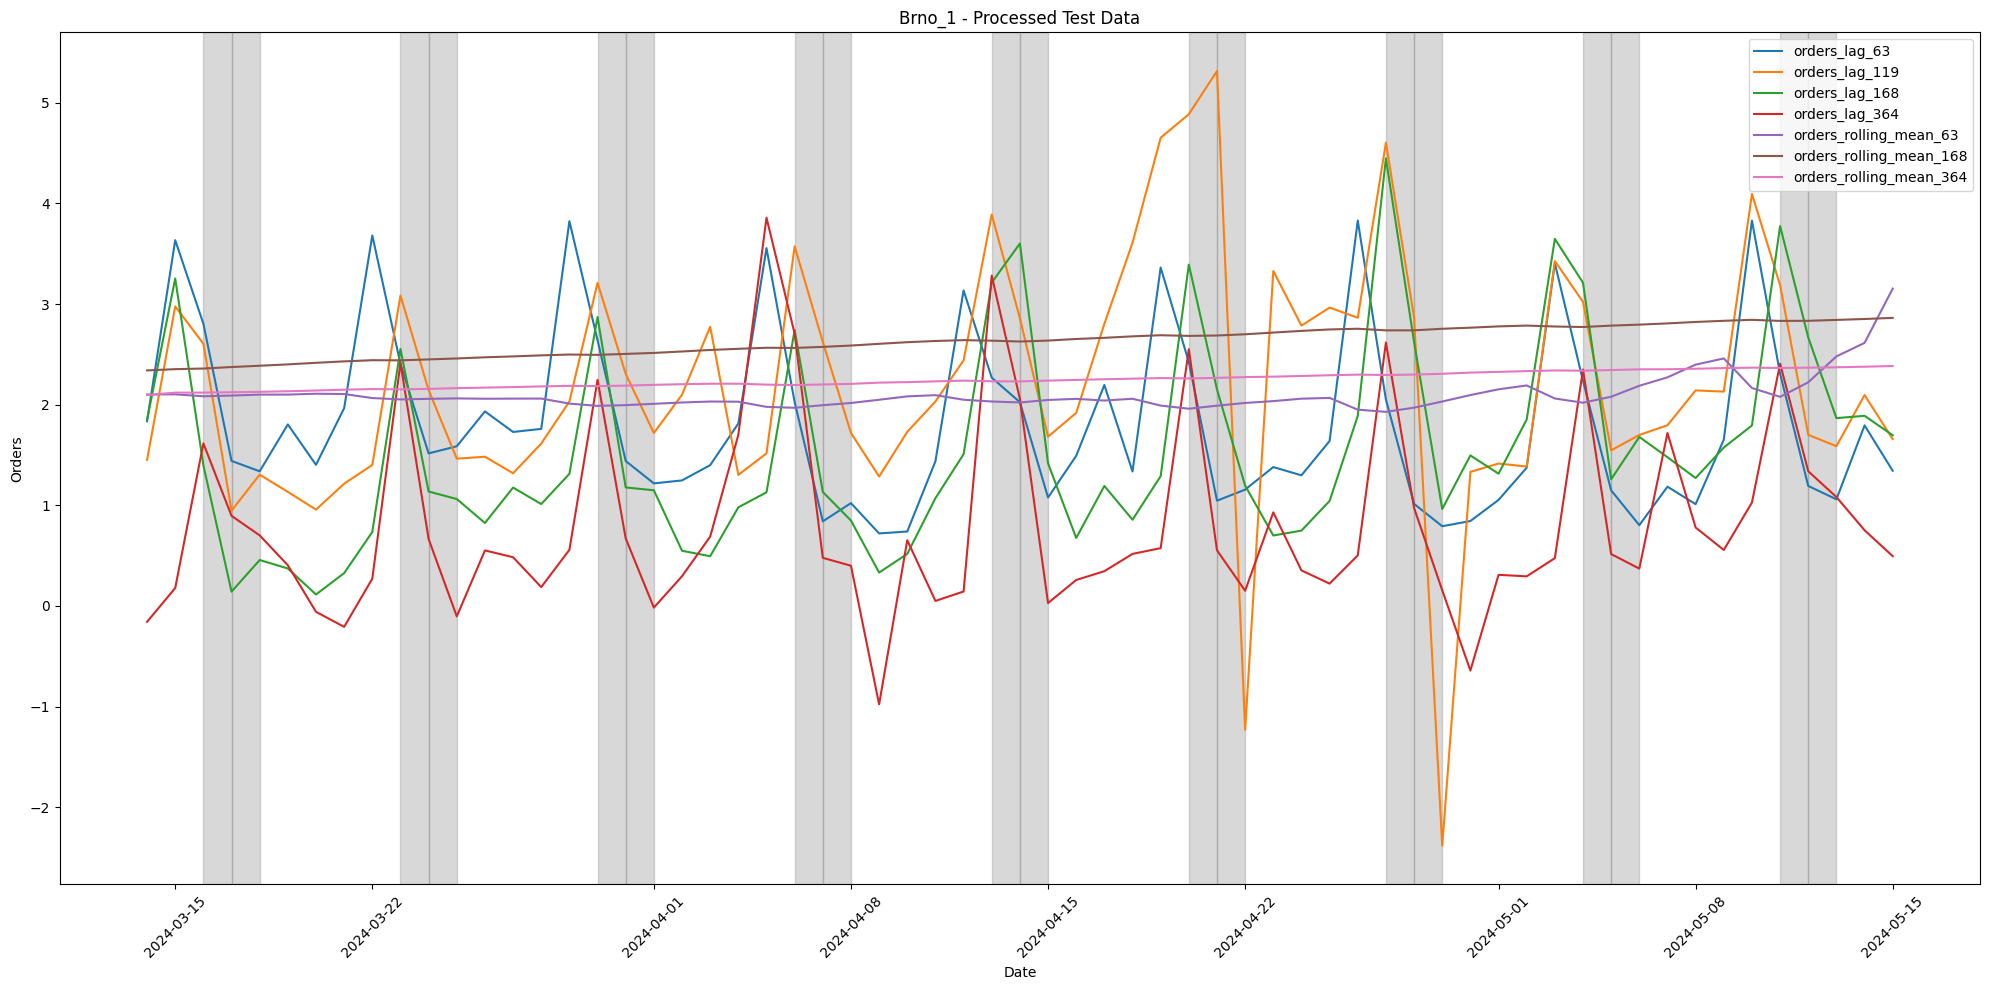

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


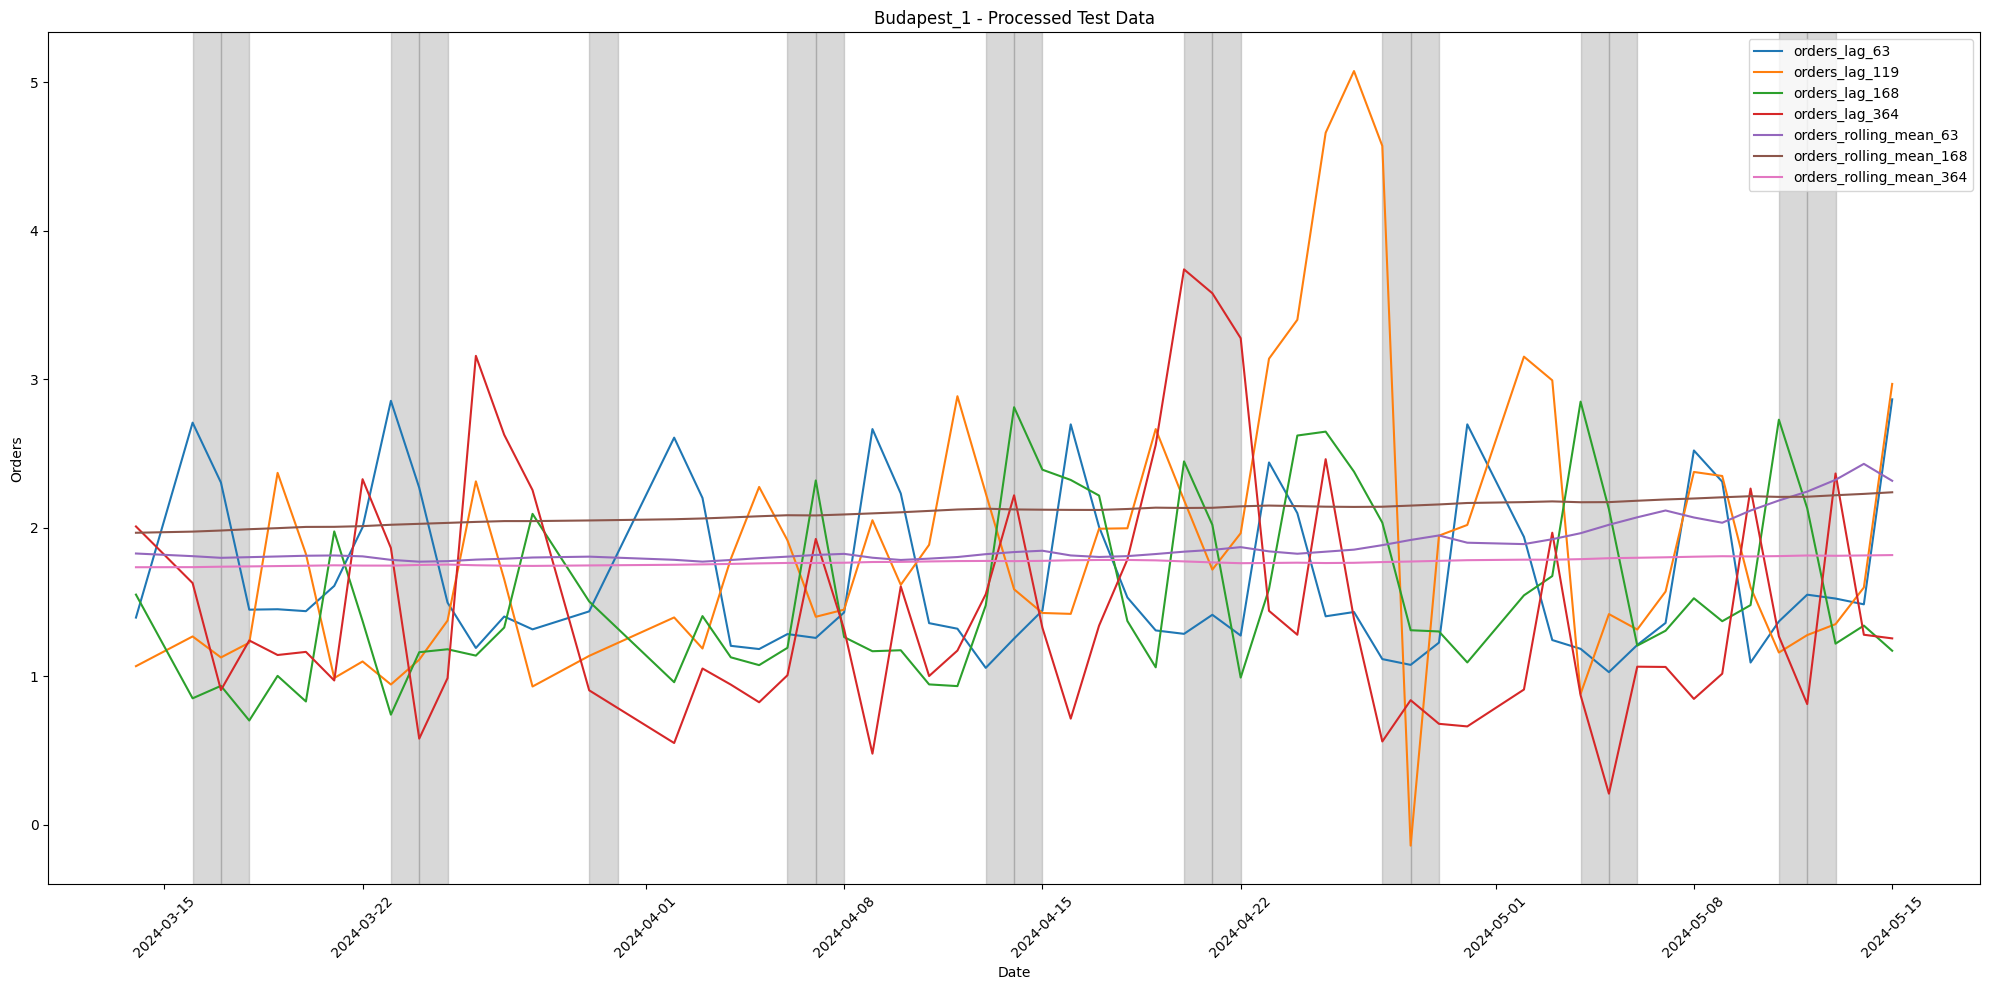

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


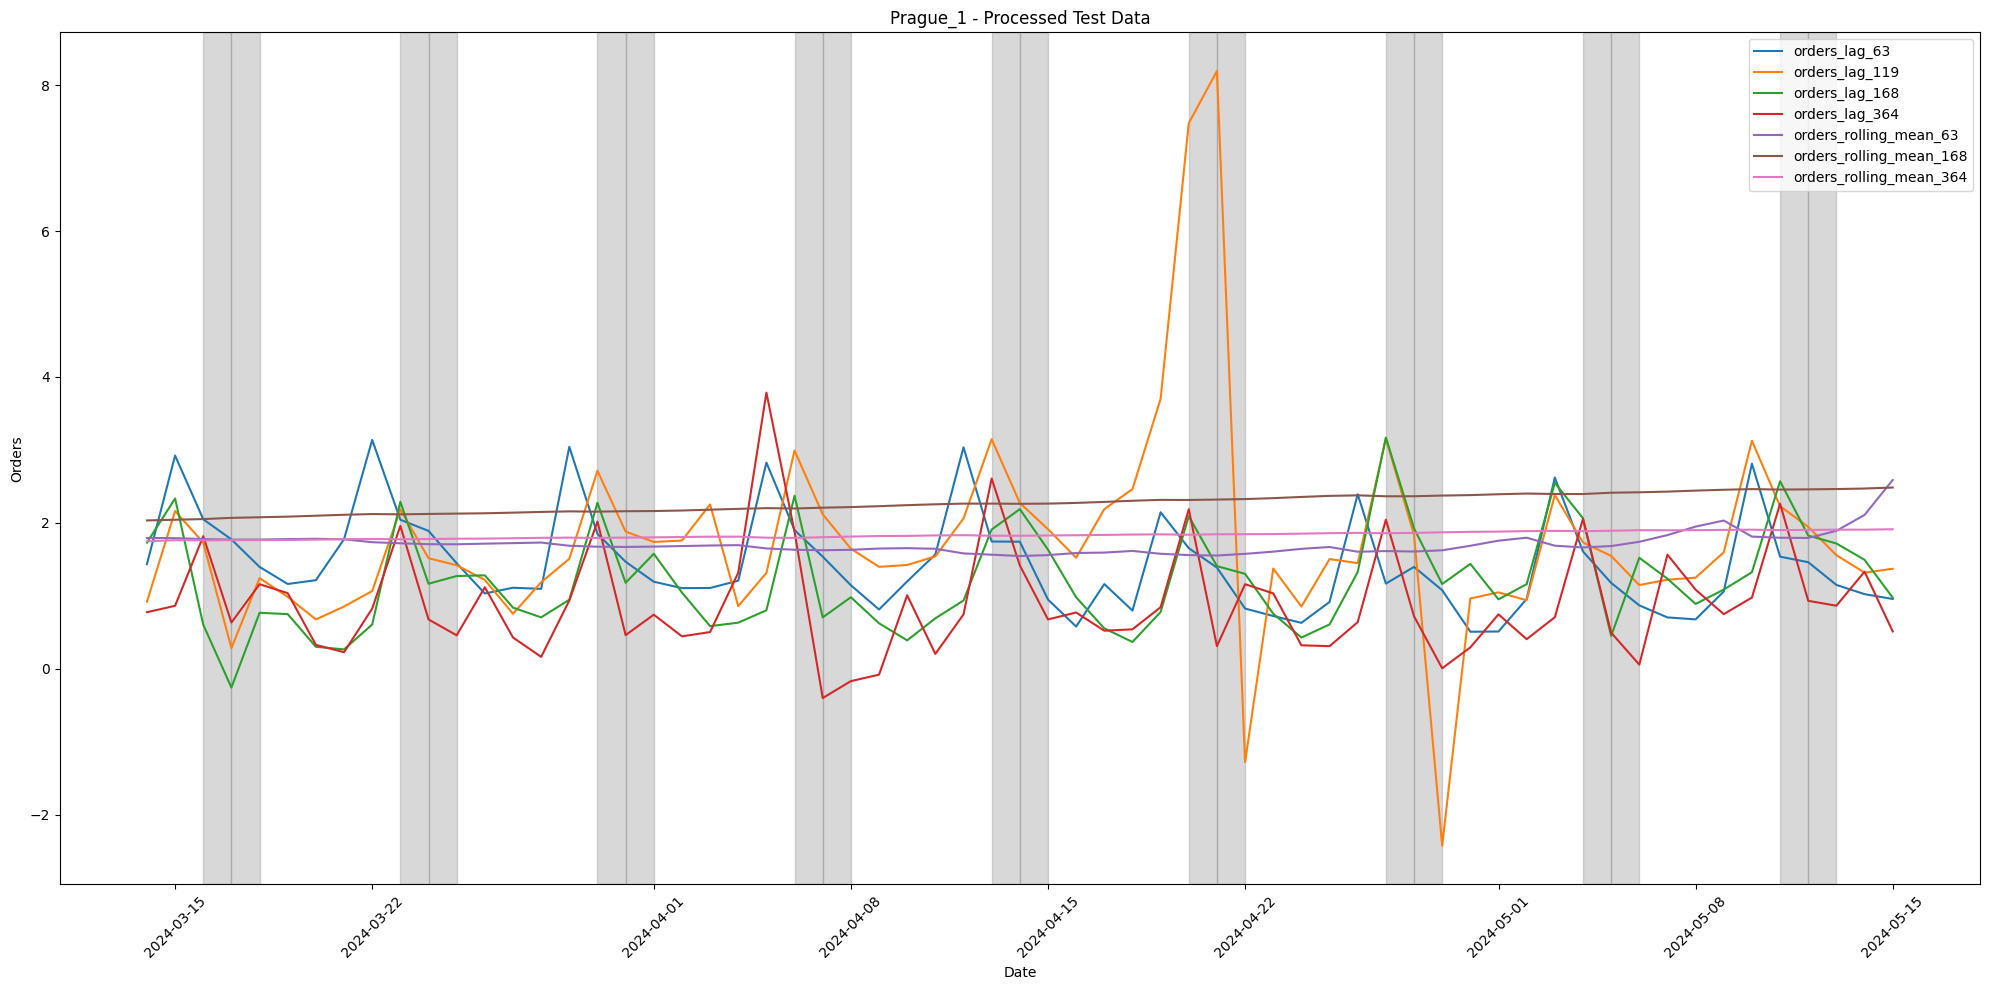

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


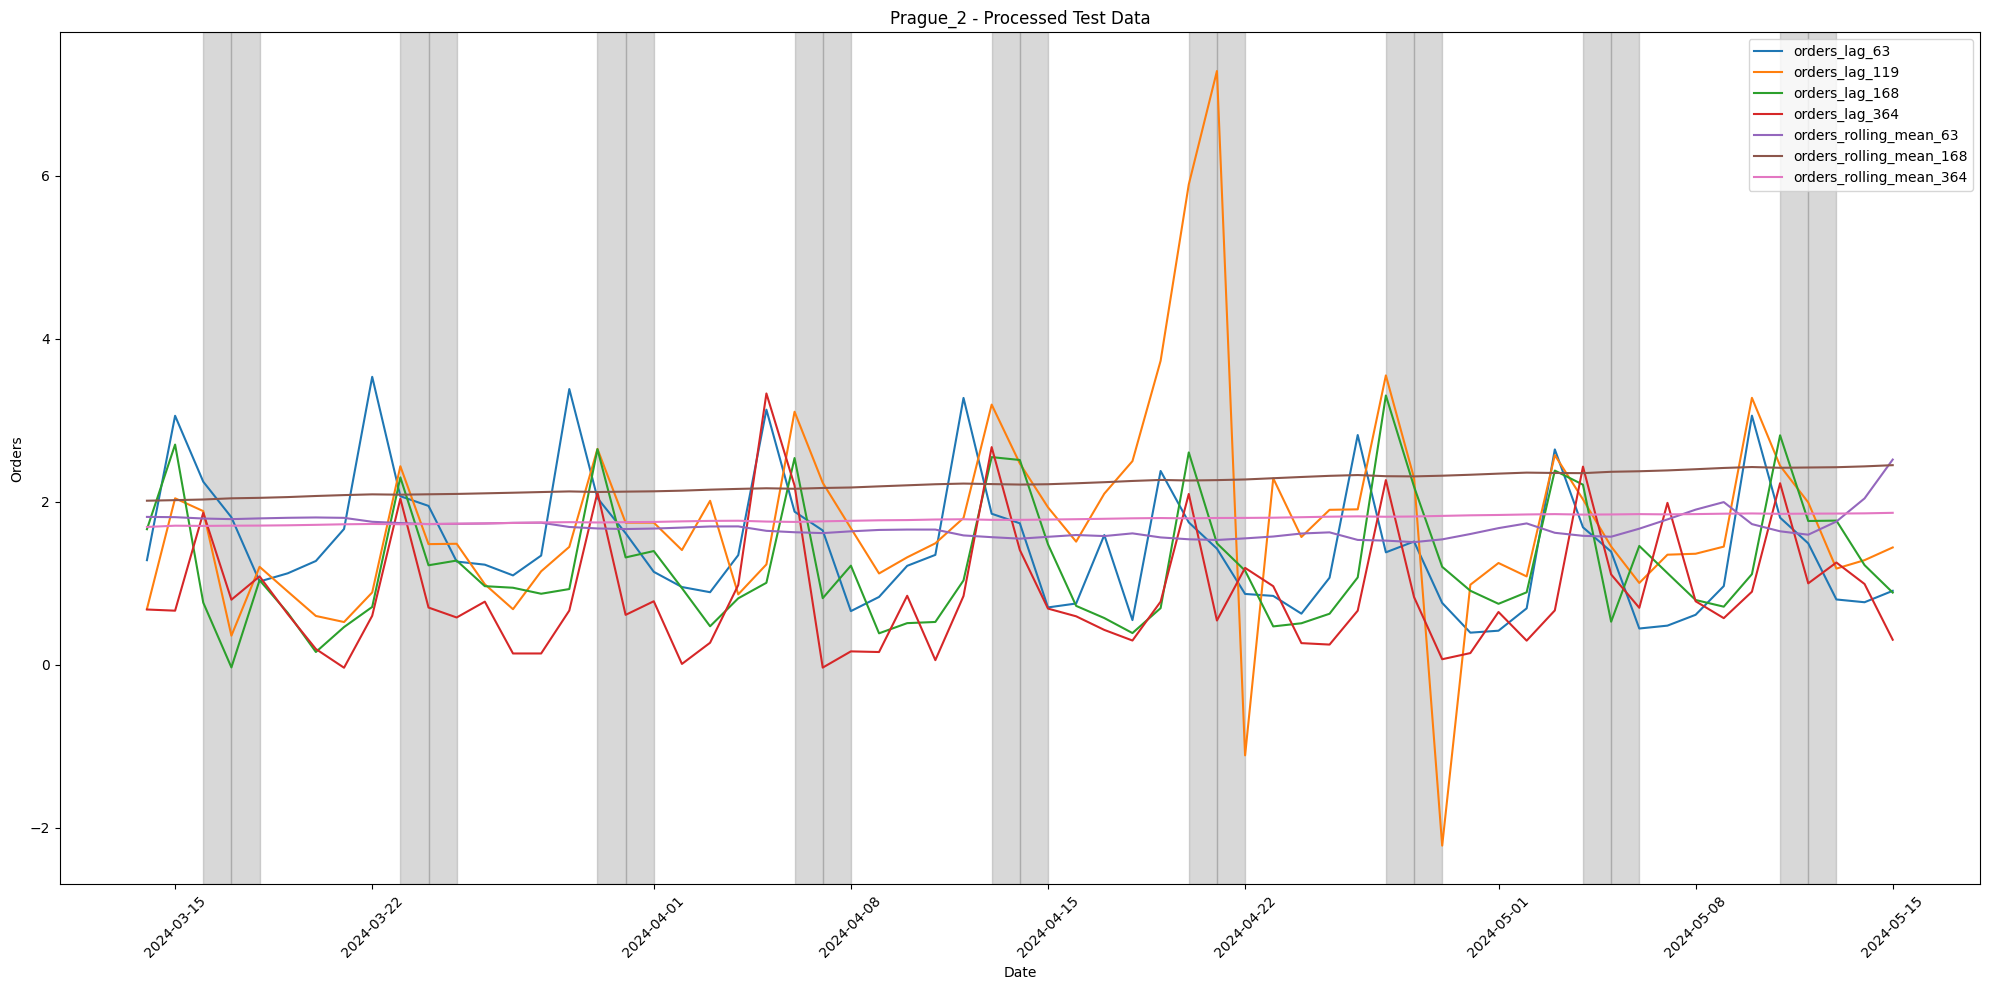

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


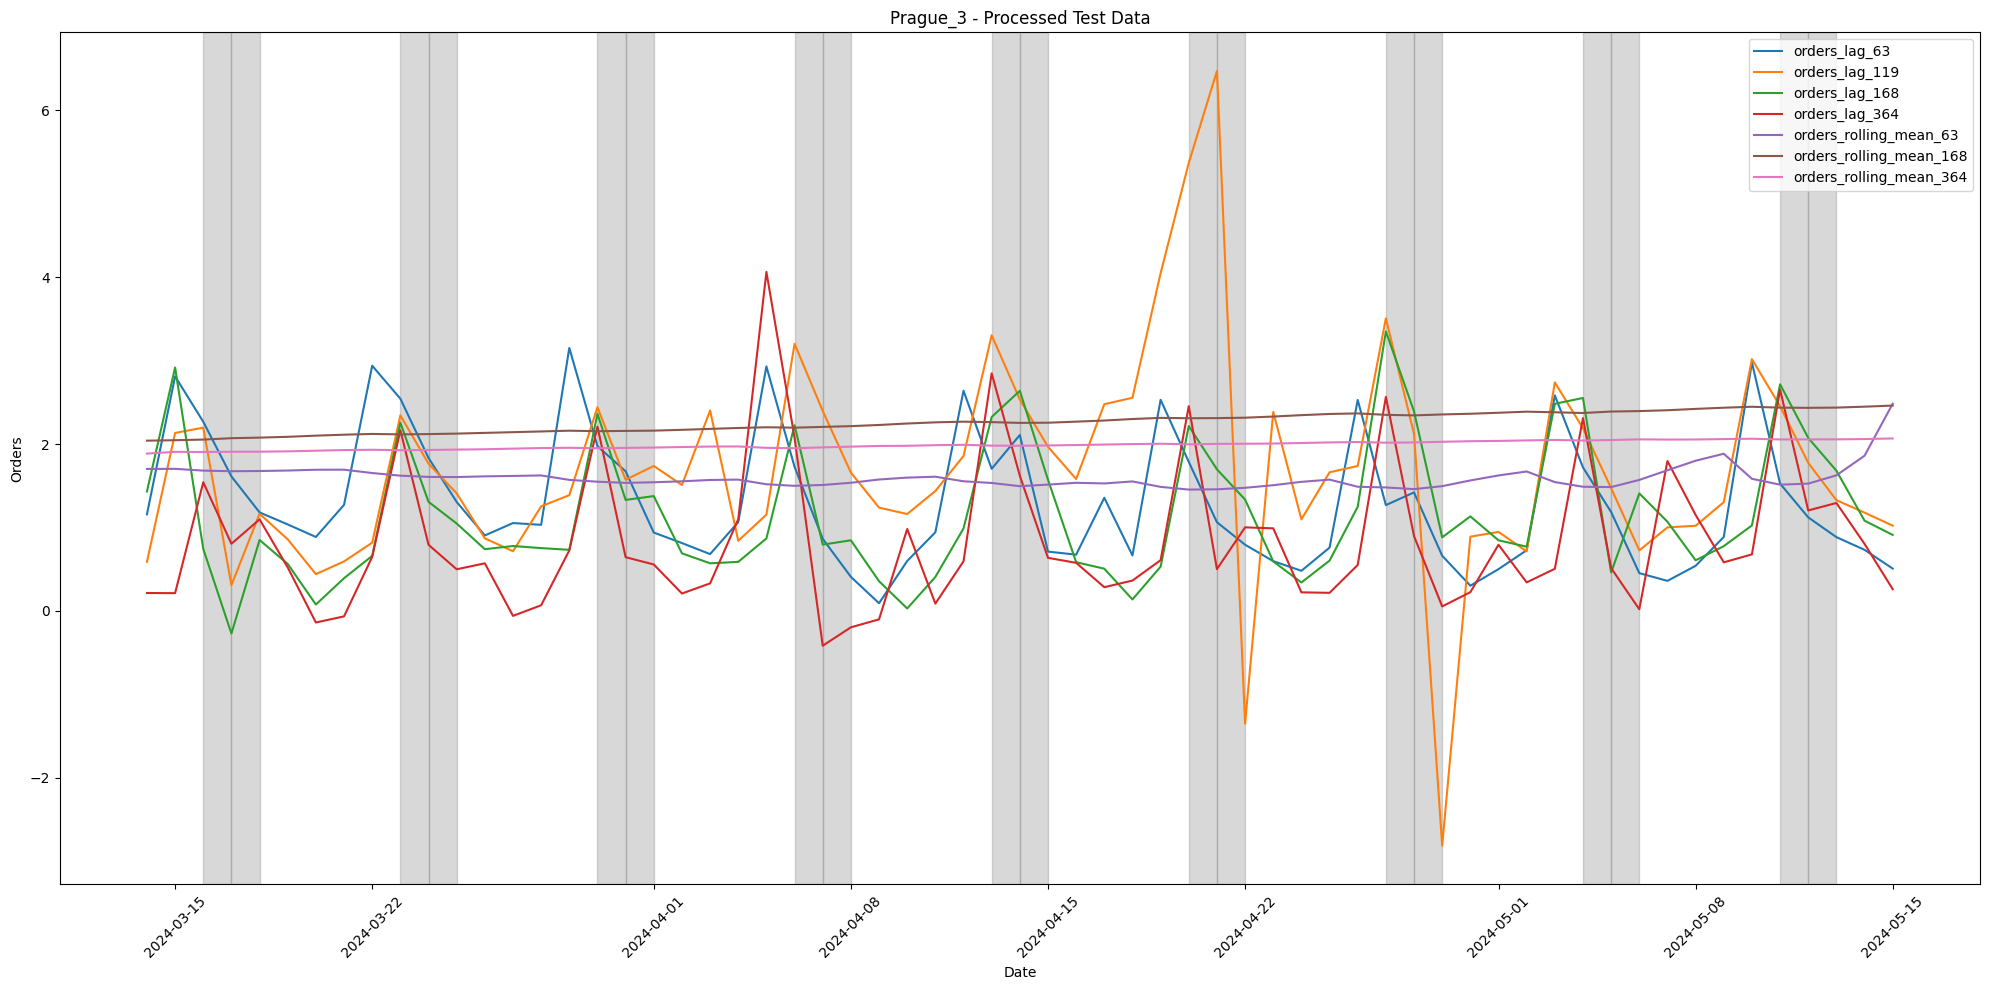

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


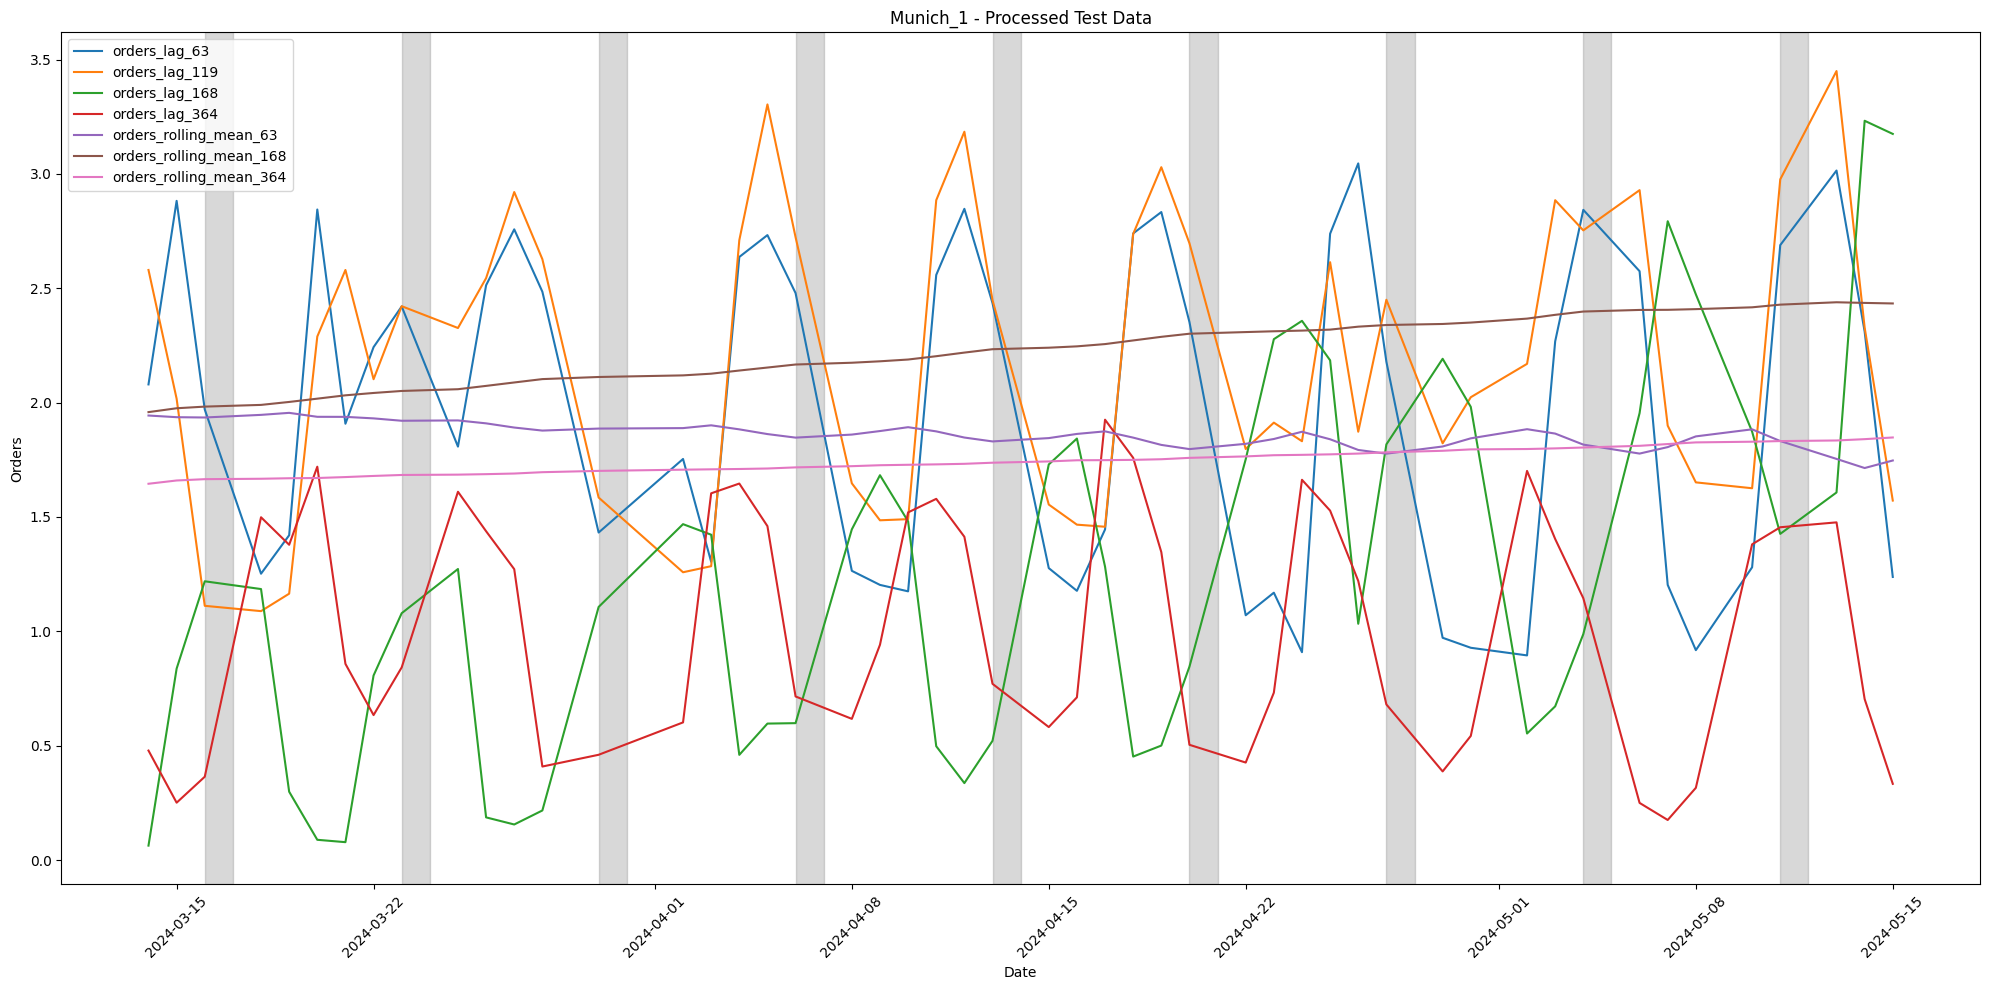

/tmp/ipykernel_33/2443794779.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


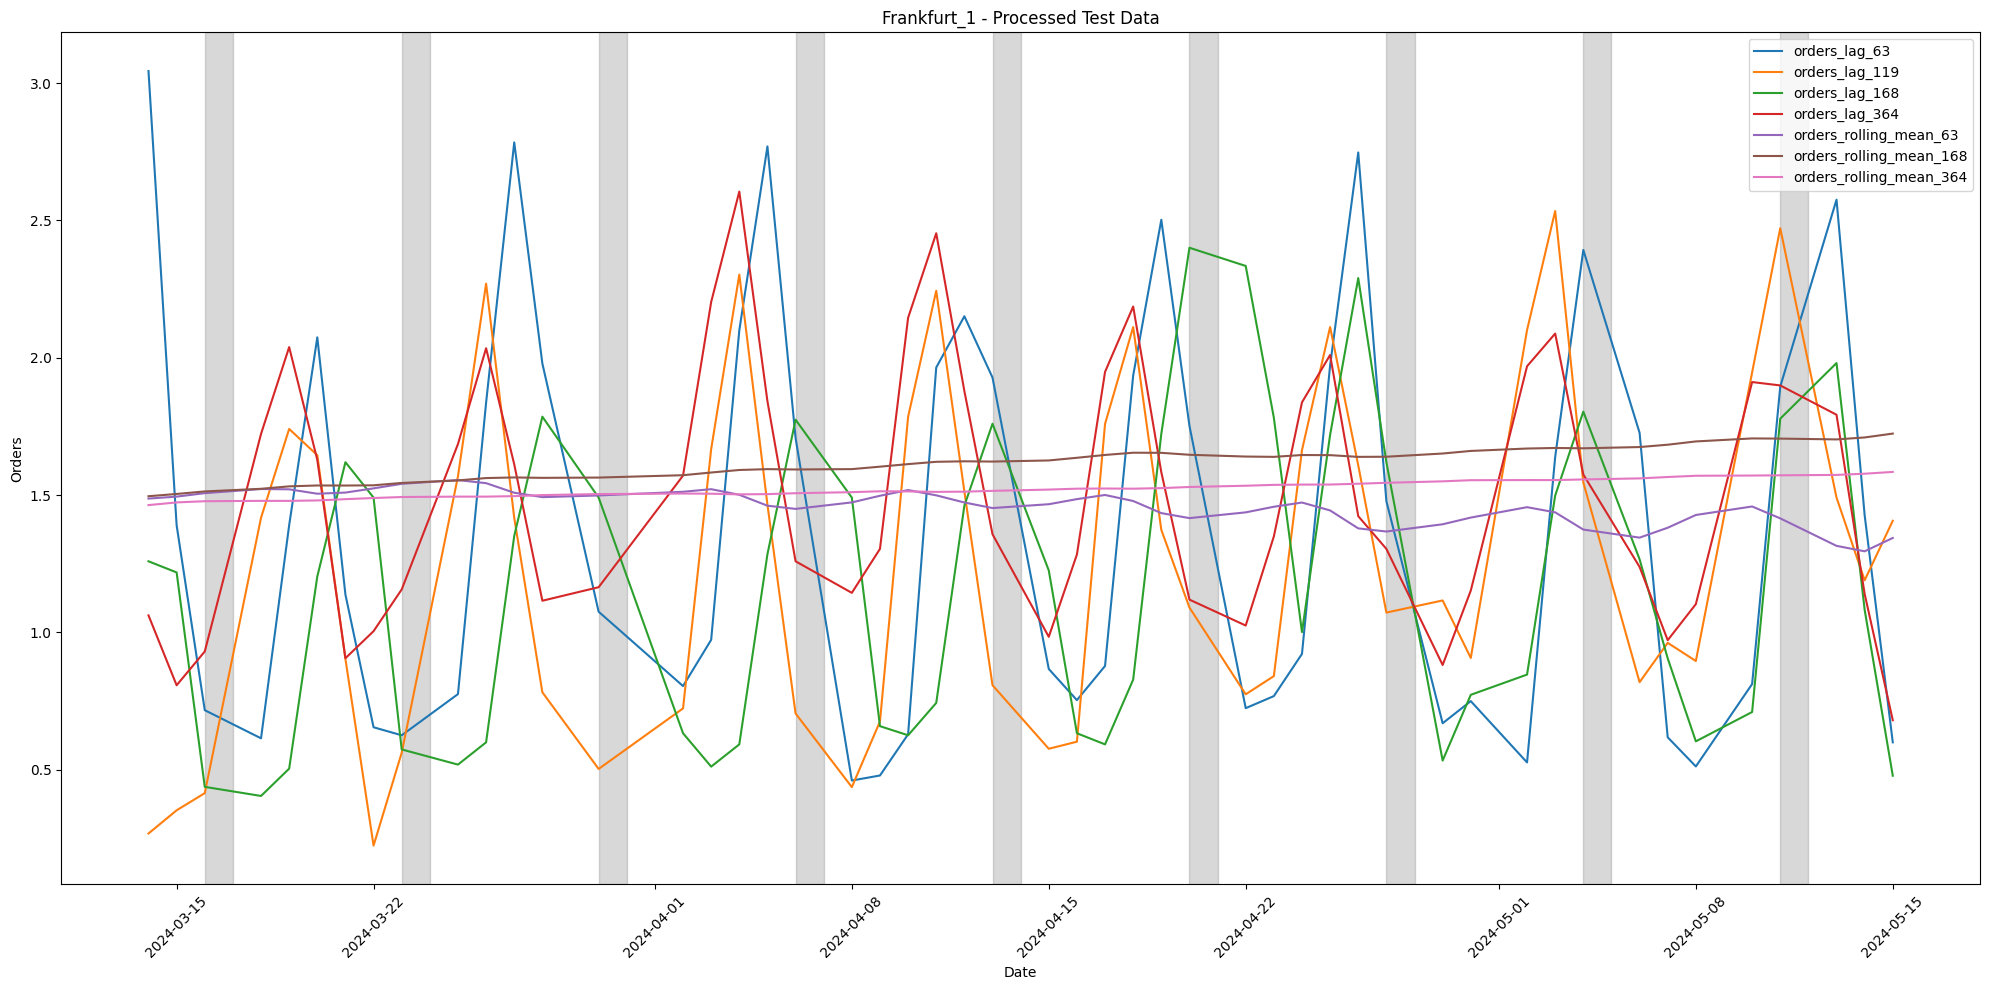

In [33]:
if LAG:
    features = [f'orders_lag_{lag}' for lag in LAG_DAYS]
    features2 = [f'orders_rolling_mean_{window}' for window in ROLLING_WINDOW]

    def is_weekend(date):
        return date.weekday() >= 5

    # Plot the processed test data:

    for wh in processed_test_df['warehouse'].unique():
        wh_df = processed_test_df[processed_test_df['warehouse'] == wh]
        plt.figure(figsize=(20, 10))

        plt.plot(wh_df["date"], wh_df[features[0]], label=features[0])
        plt.plot(wh_df["date"], wh_df[features[1]], label=features[1])
        plt.plot(wh_df["date"], wh_df[features[2]], label=features[2])
        plt.plot(wh_df["date"], wh_df[features[3]], label=features[3])
        plt.plot(wh_df["date"], wh_df[features2[0]], label=features2[0])
        plt.plot(wh_df["date"], wh_df[features2[1]], label=features2[1])
        plt.plot(wh_df["date"], wh_df[features2[2]], label=features2[2])

        # Shade weekends
        wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)
        weekends = wh_df[wh_df['is_weekend']]
        for i, row in weekends.iterrows():
            plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='gray', alpha=0.3)

        plt.title(f'{wh} - Processed Test Data')
        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Plot LAG features
Visualise LAG features of train and test back to back with the real orders

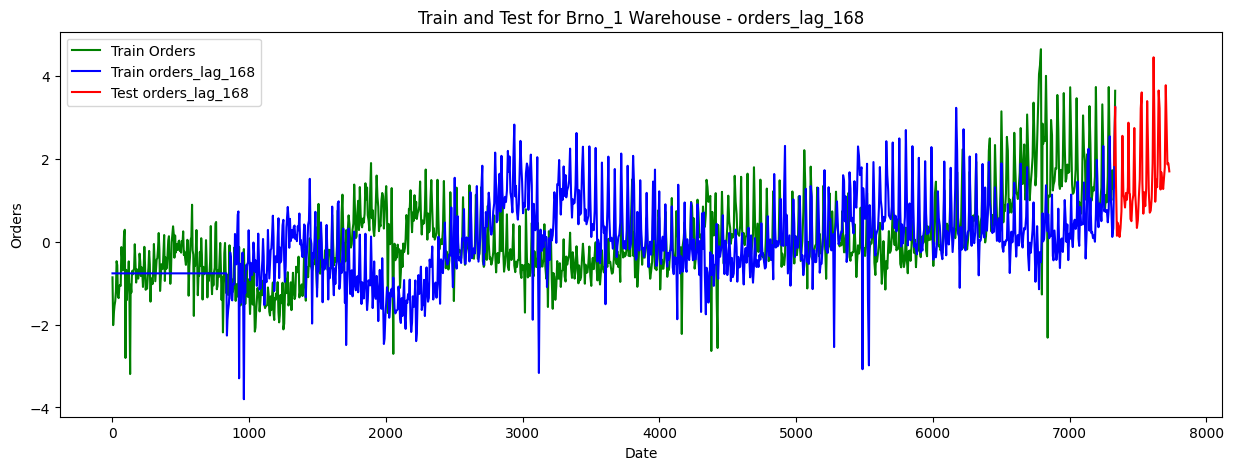

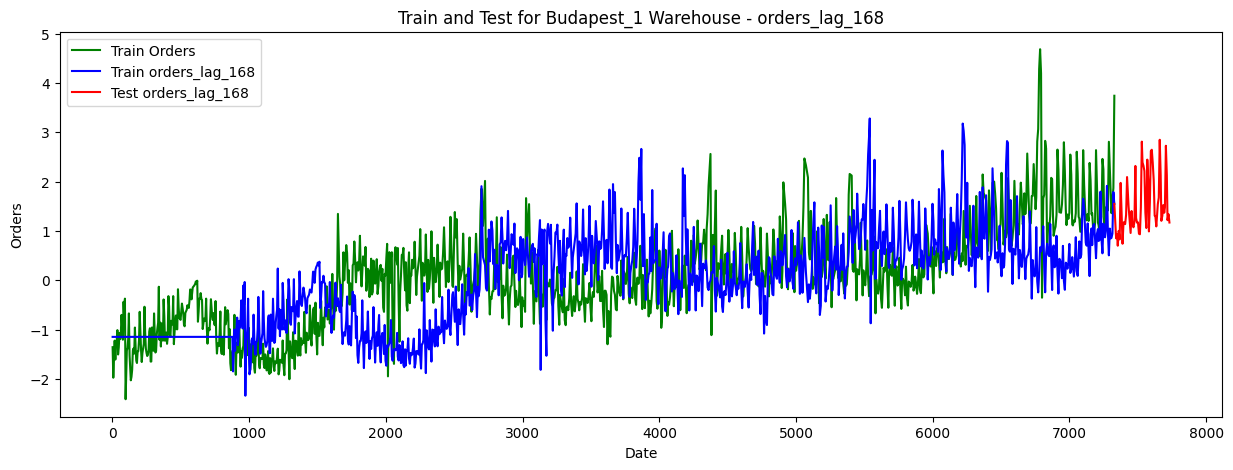

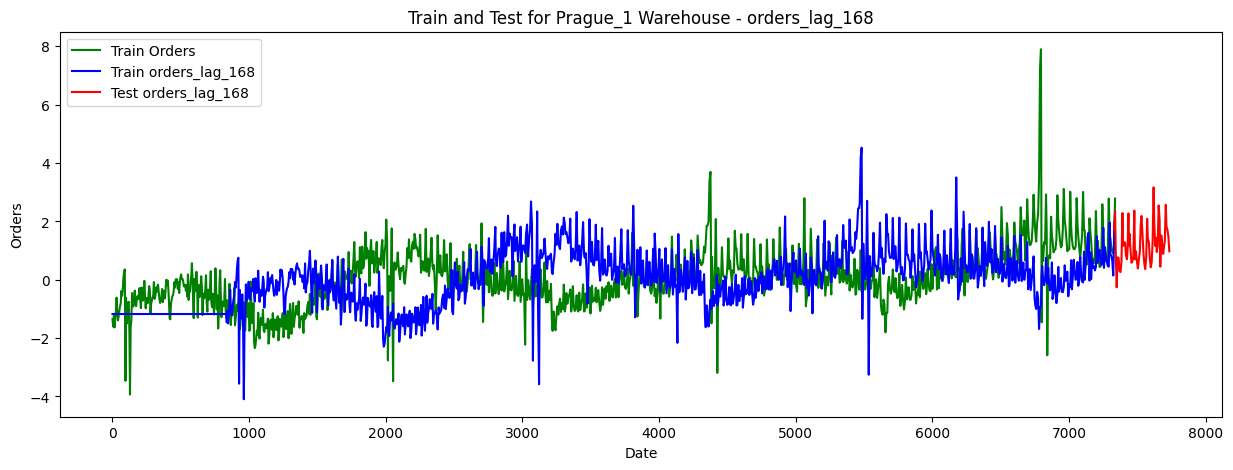

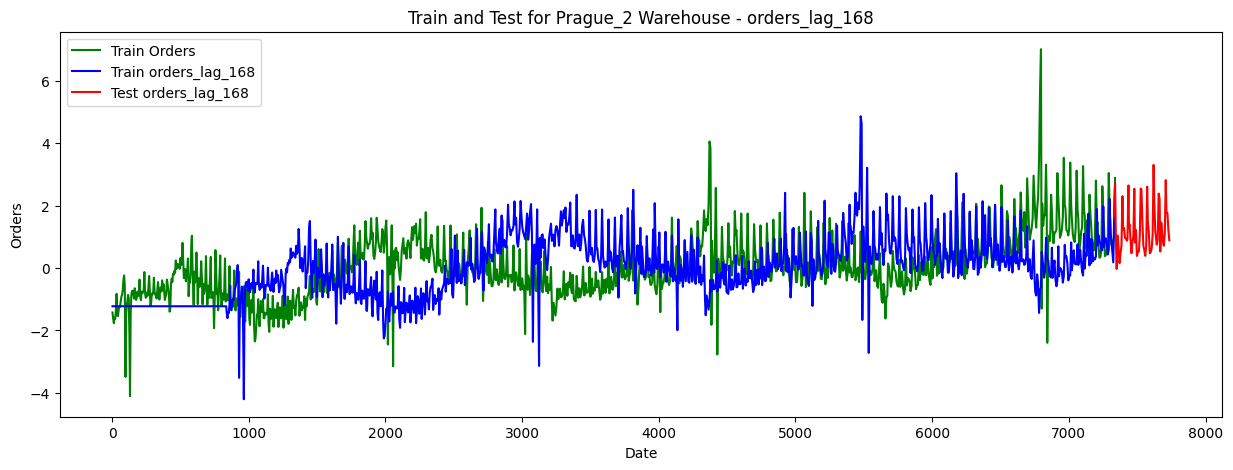

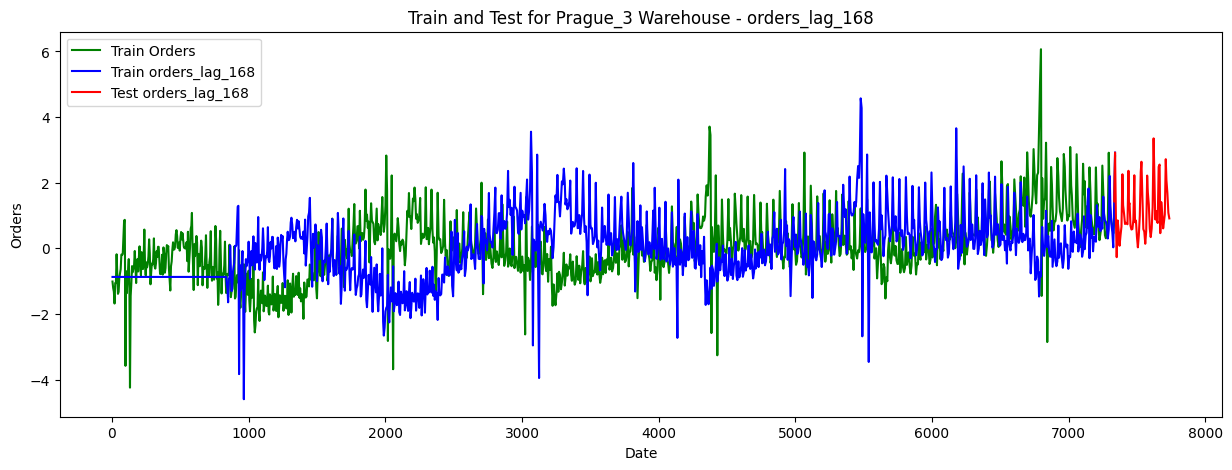

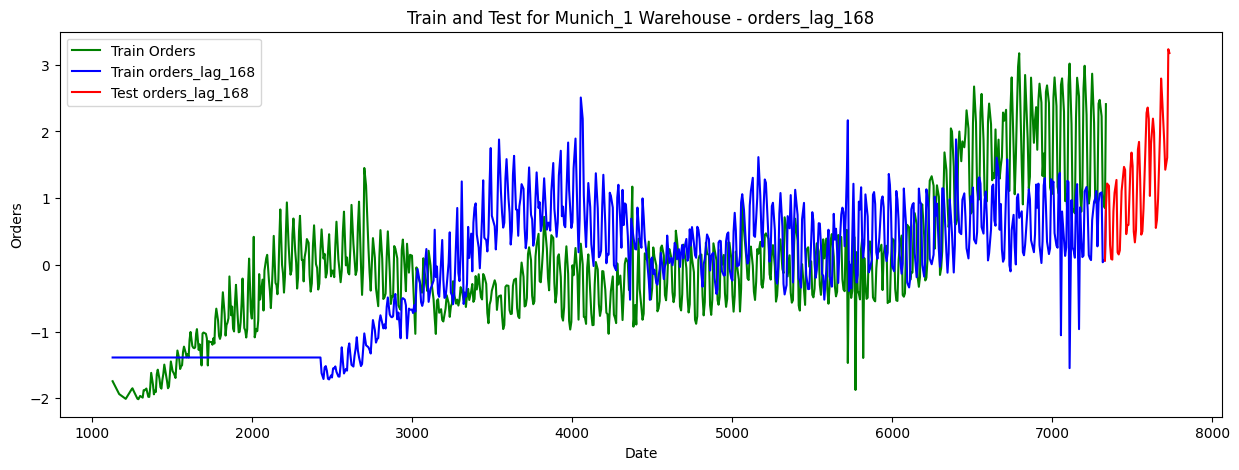

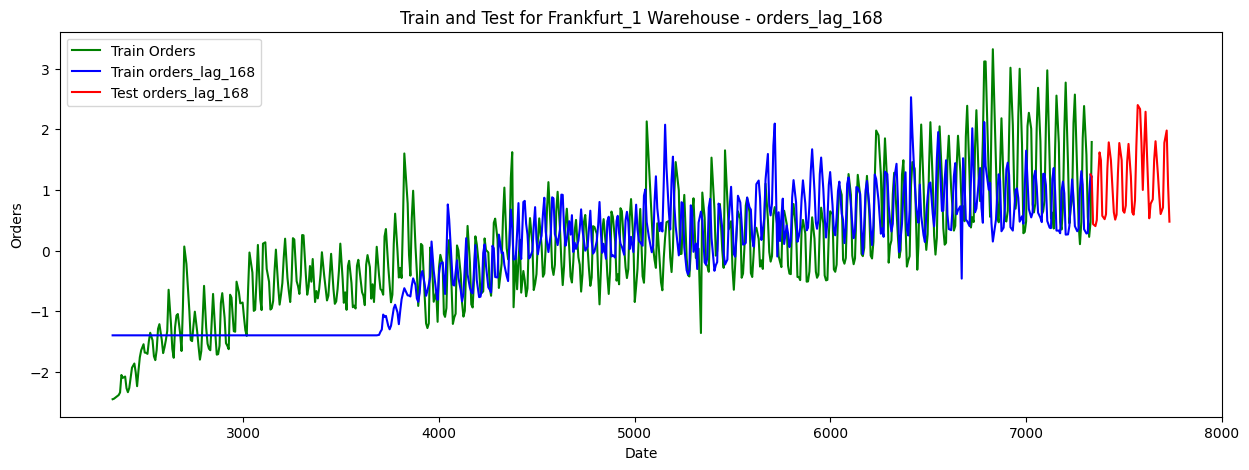

In [34]:
if LAG:
    feature = f'orders_lag_{LAG_DAYS[2]}'  # third lag feature for test data

    # Loop through the warehouse dataframes in the dictionary
    for warehouse in processed_train_data_dict.keys():
        plt.figure(figsize=(15, 5))

        # Get train data for the warehouse
        train_orders = processed_train_data_dict[warehouse][1]  # X_processed
        train_data = processed_train_data_dict[warehouse][0]  # X_processed

        # Get test data for the warehouse
        test_data = processed_test_df[processed_test_df['warehouse'] == warehouse]

        # Plot the orders and the feature
        plt.plot(train_data.index, train_orders, label='Train Orders', color='green')
        plt.plot(train_data.index, train_data[feature], label=f'Train {feature}', color='blue')
        plt.plot(test_data.index, test_data[feature], label=f'Test {feature}', color='red')
        
        plt.title(f'Train and Test for {warehouse} Warehouse - {feature}')
        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.legend()
        plt.show()

In [35]:
for warehouse, (X_processed, y_processed) in processed_train_data_dict.items():
    print(f"Warehouse: {warehouse}")
    print("Start Date:", X_processed["date"].min())
    print("End Date:", X_processed["date"].max())
    print()

Warehouse: Brno_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Budapest_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-14 00:00:00

Warehouse: Prague_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_2
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_3
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Munich_1
Start Date: 2021-07-21 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Frankfurt_1
Start Date: 2022-02-18 00:00:00
End Date: 2024-03-15 00:00:00



In [36]:
# Review dataset before training
print(len(processed_train_data_dict[warehouse][0]))
processed_train_data_dict[warehouse][0].head()


629


day_of_week_cos  day_of_week_sin  day_of_year_sin  day_of_year  \
2334        -1.116623        -0.813537         0.909951    -1.200398   
2341        -0.152291        -1.598109         0.925565    -1.190768   
2365        -0.152291         1.229390         0.984882    -1.152248   
2372        -1.116623         0.444818         0.998905    -1.142617   
2379        -1.116623        -0.813537         1.012595    -1.132987   

      days_since_start   day_cos  month_cos  day_of_year_cos  month_sin  \
2334         -1.741156 -1.148514   0.764527         0.973786   1.089843   
2341         -1.736897 -0.951425   0.764527         0.954799   1.089843   
2365         -1.719859  0.138601   0.764527         0.876079   1.089843   
2372         -1.715600  0.426710   0.764527         0.855735   1.089843   
2379         -1.711340  0.695790   0.764527         0.835137   1.089843   

       day_sin  orders_lag_63  orders_lag_119  orders_lag_168  orders_lag_364  \
2334 -0.843758      -1.869745       -1.601668       -1.396137        -0.81352   
2341 -1.064319      -1.869745       -1.601668       -1.396137        -0.81352   
2365 -1.421194      -1.869745       -1.601668       -1.396137        -0.81352   
2372 -1.359487      -1.869745       -1.601668       -1.396137        -0.81352   
2379 -1.238770      -1.869745       -1.601668       -1.396137        -0.81352   

      orders_rolling_mean_63  orders_rolling_std_63  orders_rolling_mean_168  \
2334               -2.623352              -3.438621                -2.526326   
2341               -2.618628              -3.438621                -2.521321   
2365               -2.595007              -3.250454                -2.496296   
2372               -2.571387              -3.158817                -2.471272   
2379               -2.493910              -2.491371                -2.389192   

      orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  \
2334               -4.166099                -2.683112               -4.776383   
2341               -4.166099                -2.677102               -4.776383   
2365               -3.949208                -2.647051               -4.548438   
2372               -3.843582                -2.617000               -4.437430   
2379               -3.074249                -2.518433               -3.628889   

      day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
2334            0.0            0.0            0.0            0.0   
2341            0.0            0.0            0.0            0.0   
2365            0.0            0.0            1.0            0.0   
2372            0.0            0.0            0.0            1.0   
2379            0.0            0.0            0.0            0.0   

      day_of_week_4  day_of_week_5  quarter_1  quarter_2  quarter_3  \
2334            1.0            0.0        1.0        0.0        0.0   
2341            0.0            1.0        1.0        0.0        0.0   
2365            0.0            0.0        1.0        0.0        0.0   
2372            0.0            0.0        1.0        0.0        0.0   
2379            1.0            0.0        1.0        0.0        0.0   

      quarter_4  month_1  month_2  month_3  month_4  month_5  month_6  \
2334        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2341        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2365        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2372        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2379        0.0      0.0      1.0      0.0      0.0      0.0      0.0   

      month_7  month_8  month_9  month_10  month_11  month_12  day_1  day_2  \
2334      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0   
2341      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0   
2365      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0   
2372      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0 

# Training the Model
- Create time series sequences
- Create LSTM neural net model
- Plot loss function history from traing
- Training loop

In [37]:
def create_sequences(X, y=None, time_steps=10):
    sequences = []
    targets = []

    if y is not None:
        # Training mode
        if len(X) > time_steps:
            generator = TimeseriesGenerator(X.values, 
                                            y,
                                            length=time_steps, 
                                            batch_size=1)
            
            for i in range(len(generator)):
                x, y_seq = generator[i]
                sequences.append(x)
                targets.append(y_seq)
        
        X_seq = np.array(sequences)
        y_seq = np.array(targets)
        X_seq = np.squeeze(X_seq, axis=1)
        y_seq = np.squeeze(y_seq, axis=1)
        
        print(f"Training mode - final shape: X: {X_seq.shape}, y: {y_seq.shape}")
        
        return X_seq, y_seq
    
    else:
        # Inference mode
        dummy_targets = np.zeros(len(X))  # Create dummy targets
        generator = TimeseriesGenerator(X.values, 
                                        dummy_targets, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, _ = generator[i]
            sequences.append(x)
        
        X_seq = np.array(sequences)
        X_seq = np.squeeze(X_seq, axis=1)
        
        print(f"Inference mode - final shape: X: {X_seq.shape}")
        
        return X_seq


## Model Architecture
Model from experimenting, simpler gets more constant resulets

In [38]:
from tensorflow.keras.regularizers import l2


def create_model(input_shape, lr=1e-3, warehouse="None"):

    model = Sequential()
    model.add(Input(shape=input_shape))
    
    if warehouse in ["Brno_1", "Prague_1", "Prague_2", "Prague_3"]:

        #model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2()))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.4))
        
        model.add(LSTM(1024, activation='relu', return_sequences=False))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
        #model.add(LSTM(512, activation='relu', kernel_regularizer=l2()))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
        #model.add(Dense(512))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
    
        
    elif warehouse in ["Munich_1", "Frankfurt_1"]:

        #model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2()))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.3))
        
        model.add(LSTM(1024, activation='relu', return_sequences=False))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
        #model.add(LSTM(256, activation='relu', kernel_regularizer=l2()))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
        #model.add(Dense(256))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
    
    elif warehouse in ["Budapest_1"]:
        #model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2()))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.3))
        
        model.add(LSTM(1024, activation='relu',return_sequences=False))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
        #model.add(LSTM(512, activation='relu', kernel_regularizer=l2()))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
        #model.add(Dense(512))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.2))
        
    else:
        print("No model selected, unknown warehouse timeline.")
        return

    model.add(Dense(1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))
    #model.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.9))
                  
    return model


In [39]:
def plot_loss(history, warehouse):
    plt.figure(figsize=(12, 8))

    # training and validation loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    
    # minimum validation loss
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
    plt.axvline(min_val_loss_epoch, linestyle='--', color='gray', linewidth=1)
    plt.text(min_val_loss_epoch, min_val_loss, f'Min Val Loss: {min_val_loss:.4f}', 
             verticalalignment='bottom', horizontalalignment='right', color='gray', fontsize=10)
    
    plt.title(f'Training and Validation Loss for Warehouse: {warehouse}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.savefig(f'training_validation_loss_{warehouse}.png', dpi=300)
    
    plt.show()

In [40]:
#print nan values for every warehouse in train dataset dict:
for warehouse in processed_train_data_dict.keys():
    print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
    print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")
    
    if FILL:
        feat, targ = processed_train_data_dict[warehouse]

        feat = feat.fillna(0)
        targ = np.nan_to_num(targ, nan=0.0)
        processed_train_data_dict[warehouse] = (feat, targ)

if FILL:
    print("\n After FILL:")
    for warehouse in processed_train_data_dict.keys():
        print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
        print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")


Nan X values for Brno_1: 0
nan y values for Brno_1: 0
Nan X values for Budapest_1: 0
nan y values for Budapest_1: 0
Nan X values for Prague_1: 0
nan y values for Prague_1: 0
Nan X values for Prague_2: 0
nan y values for Prague_2: 0
Nan X values for Prague_3: 0
nan y values for Prague_3: 0
Nan X values for Munich_1: 0
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 0
nan y values for Frankfurt_1: 0

 After FILL:
Nan X values for Brno_1: 0
nan y values for Brno_1: 0
Nan X values for Budapest_1: 0
nan y values for Budapest_1: 0
Nan X values for Prague_1: 0
nan y values for Prague_1: 0
Nan X values for Prague_2: 0
nan y values for Prague_2: 0
Nan X values for Prague_3: 0
nan y values for Prague_3: 0
Nan X values for Munich_1: 0
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 0
nan y values for Frankfurt_1: 0


## Training Loop
Training loop, create sequences, train-test split, create model, use callbacks for trainig, fit the model.

Training model for warehouse: Brno_1
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
Epoch 1/100
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5157
Epoch 1: val_loss improved from inf to 0.24654, saving model to model_Brno_1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.5128 - val_loss: 0.2465
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2329
Epoch 2: val_loss improved from 0.24654 to 0.20111, saving model to model_Brno_1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2330 - val_loss: 0.2011
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2128
Epoch 3: val_loss improved from 0.20111 to 0.19721, saving model to model_Brno_1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2127 - val_loss: 0.1972
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1691
Epoch 4: val_loss did not improve from 0.19721
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1693 - val_loss: 0.2071
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━

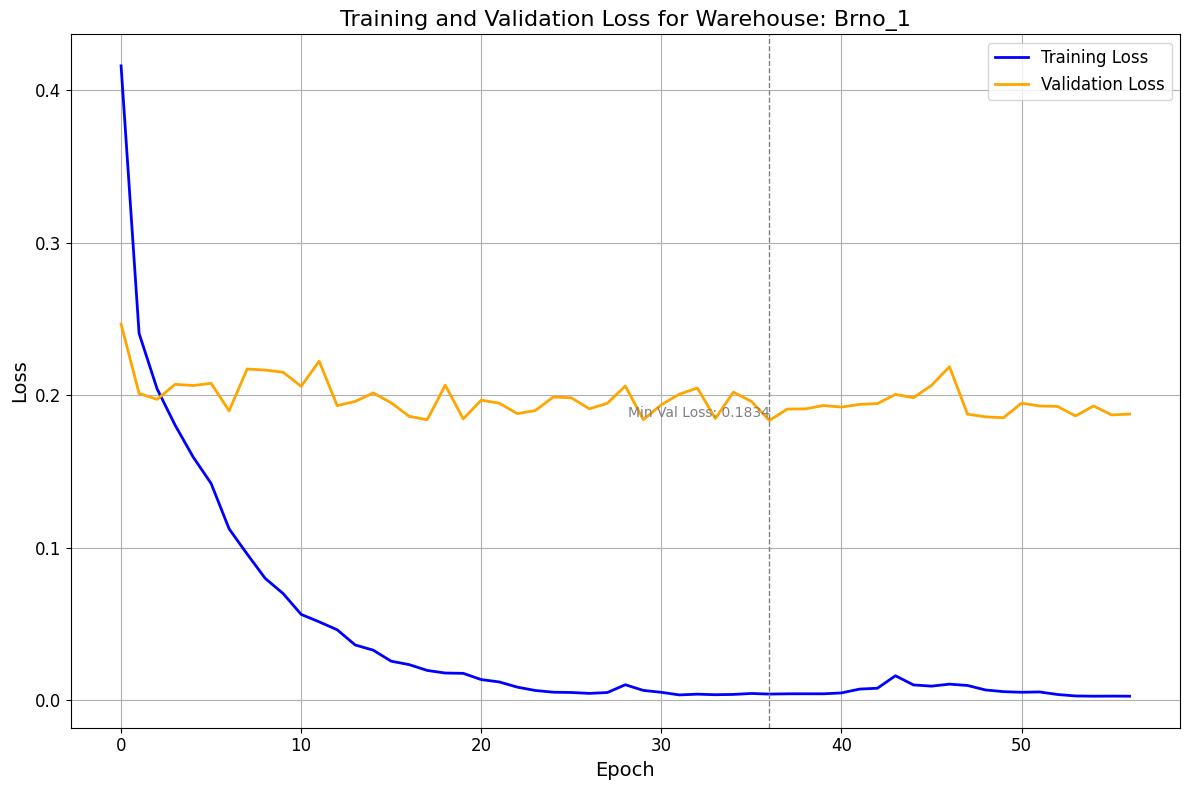

Training model for warehouse: Budapest_1
Training mode - final shape: X: (1153, 1, 84), y: (1153,)
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5307
Epoch 1: val_loss improved from inf to 0.19079, saving model to model_Budapest_1.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.5275 - val_loss: 0.1908
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1684
Epoch 2: val_loss improved from 0.19079 to 0.15179, saving model to model_Budapest_1.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1684 - val_loss: 0.1518
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1476
Epoch 3: val_loss did not improve from 0.15179
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1476 - val_loss: 0.1519
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1160
Epoch 4: val_loss improved from 0.15179 to 0.15021, saving model to model_Budapest_1.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1161 - val_loss: 0.1502
Epoch 5/100
65/65 ━━━

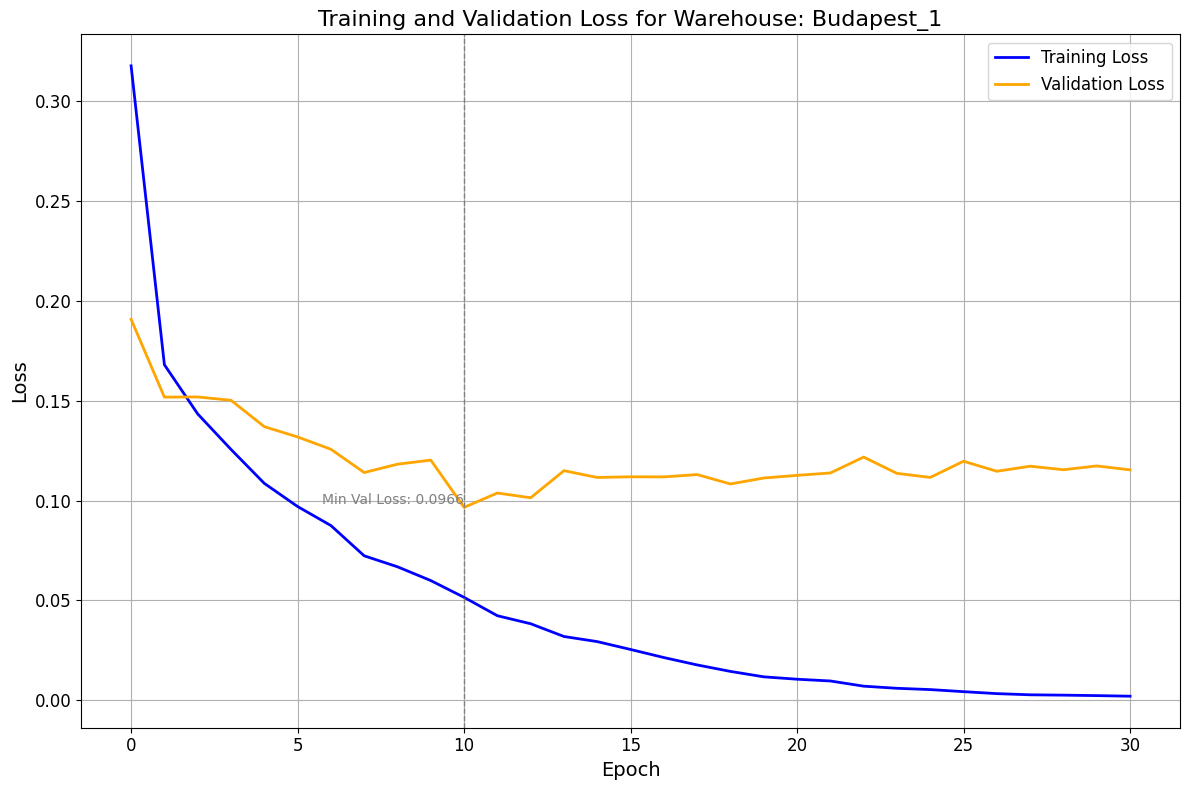

Training model for warehouse: Prague_1
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
Epoch 1/100
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5111
Epoch 1: val_loss improved from inf to 0.19834, saving model to model_Prague_1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.5099 - val_loss: 0.1983
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2887
Epoch 2: val_loss improved from 0.19834 to 0.15994, saving model to model_Prague_1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2889 - val_loss: 0.1599
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2036
Epoch 3: val_loss did not improve from 0.15994
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.2044 - val_loss: 0.1732
Epoch 4/100
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1964
Epoch 4: val_loss improved from 0.15994 to 0.15119, saving model to model_Prague_1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.1973 - val_loss: 0.1512
Epoch 5/100
66/67 ━━━━━━━━━━━

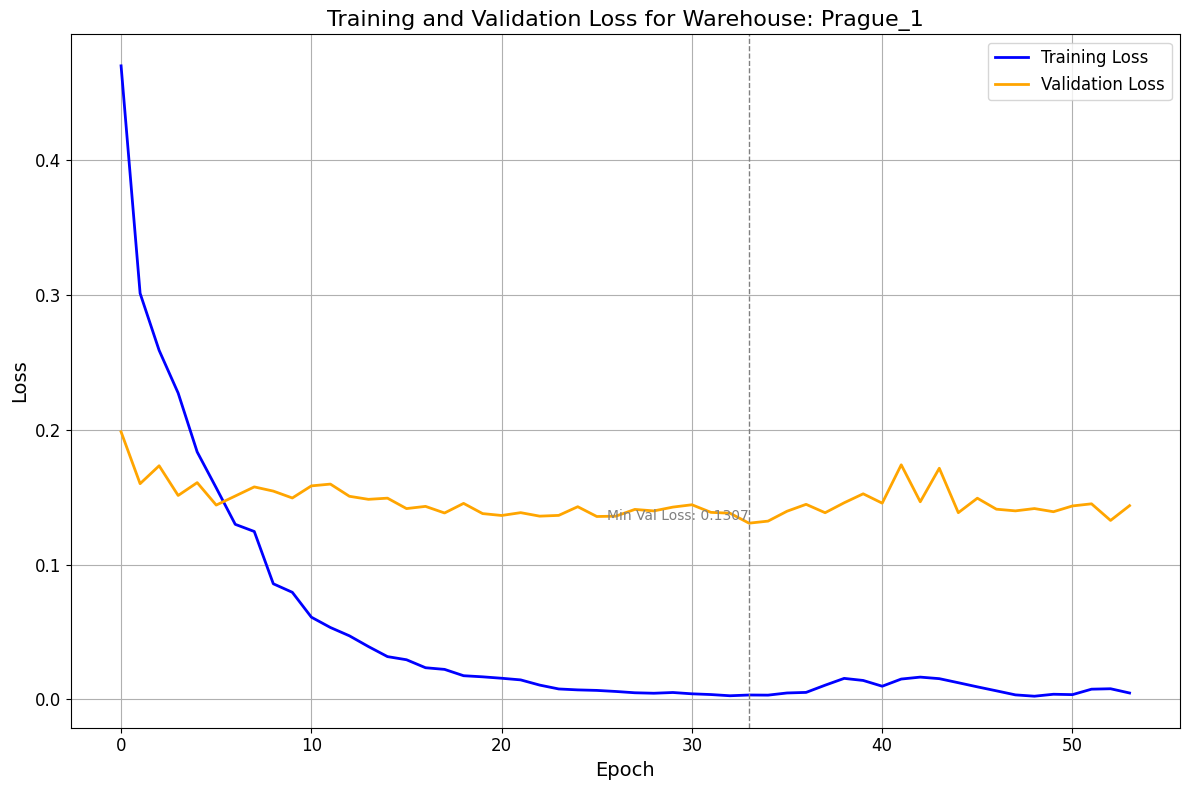

Training model for warehouse: Prague_2
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5997
Epoch 1: val_loss improved from inf to 0.22242, saving model to model_Prague_2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.5978 - val_loss: 0.2224
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3326
Epoch 2: val_loss improved from 0.22242 to 0.15676, saving model to model_Prague_2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.3321 - val_loss: 0.1568
Epoch 3/100
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2576
Epoch 3: val_loss improved from 0.15676 to 0.15095, saving model to model_Prague_2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.2571 - val_loss: 0.1510
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2040
Epoch 4: val_loss did not improve from 0.15095
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2042 - val_loss: 0.1529
Epoch 5/100
67/67 ━━━━━━━━━━━

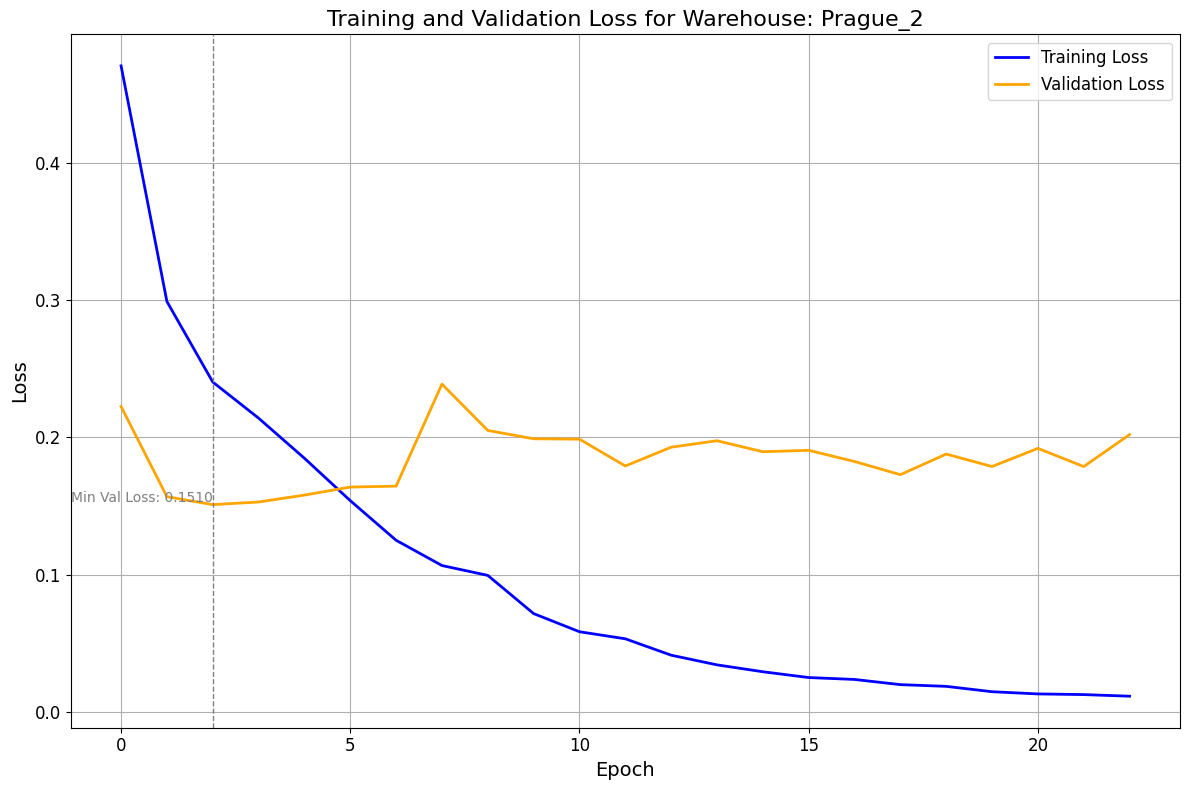

Training model for warehouse: Prague_3
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7914
Epoch 1: val_loss improved from inf to 0.24147, saving model to model_Prague_3.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.7880 - val_loss: 0.2415
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2978
Epoch 2: val_loss improved from 0.24147 to 0.18439, saving model to model_Prague_3.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2983 - val_loss: 0.1844
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2766
Epoch 3: val_loss did not improve from 0.18439
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2768 - val_loss: 0.2021
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2899
Epoch 4: val_loss did not improve from 0.18439
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2891 - val_loss: 0.2165
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1780
Epoc

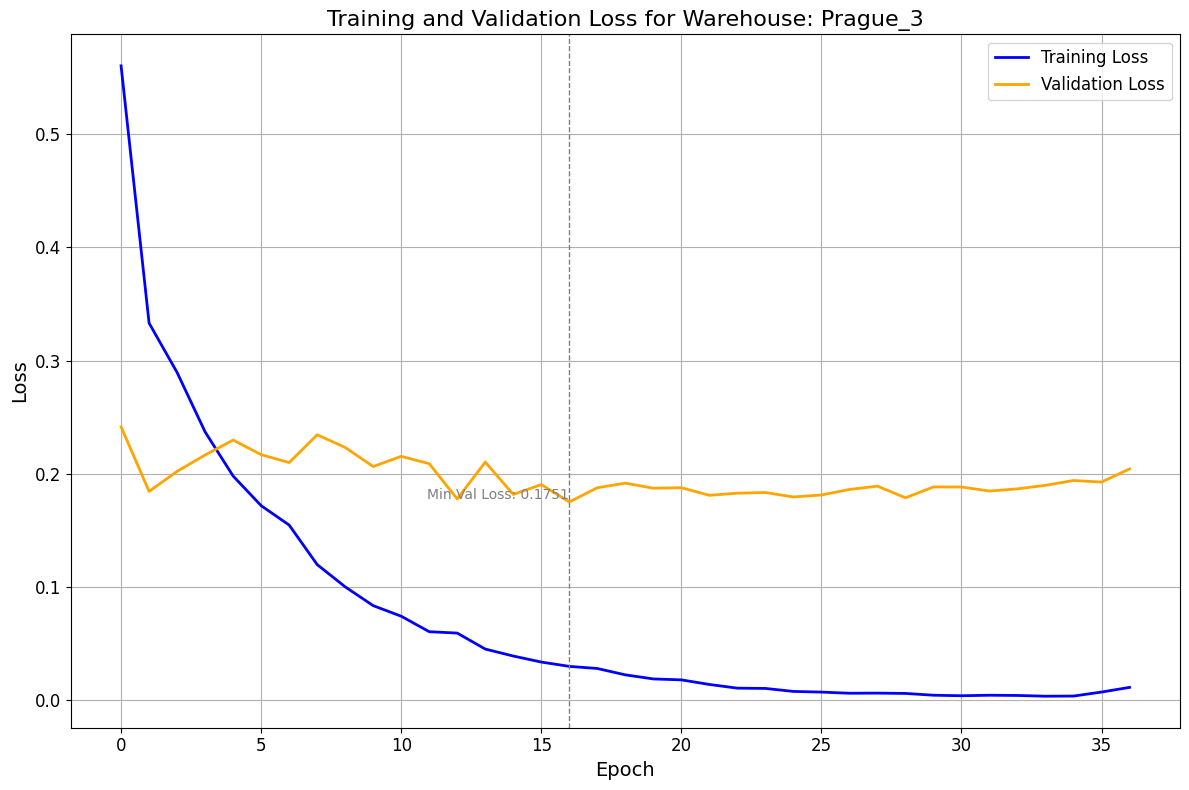

Training model for warehouse: Munich_1
Training mode - final shape: X: (784, 1, 83), y: (784,)
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5701
Epoch 1: val_loss improved from inf to 0.15735, saving model to model_Munich_1.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.5643 - val_loss: 0.1574
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0882
Epoch 2: val_loss improved from 0.15735 to 0.13653, saving model to model_Munich_1.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0884 - val_loss: 0.1365
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0707
Epoch 3: val_loss improved from 0.13653 to 0.12383, saving model to model_Munich_1.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0710 - val_loss: 0.1238
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0689
Epoch 4: val_loss did not improve from 0.12383
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0691 - val_loss: 0.1436
Epoch 5/100
45/45 ━━━━━━━━━━━━━

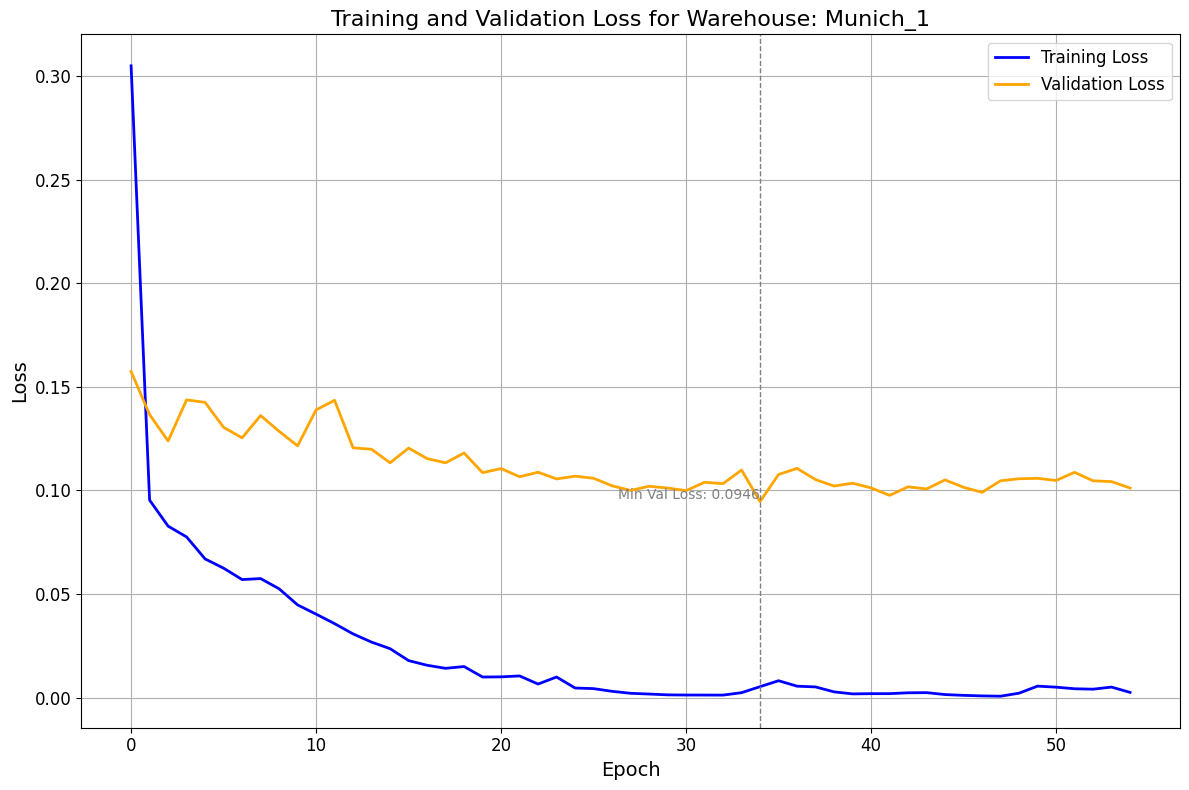

Training model for warehouse: Frankfurt_1
Training mode - final shape: X: (628, 1, 81), y: (628,)
Epoch 1/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4745
Epoch 1: val_loss improved from inf to 0.24050, saving model to model_Frankfurt_1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.4658 - val_loss: 0.2405
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1398
Epoch 2: val_loss improved from 0.24050 to 0.18450, saving model to model_Frankfurt_1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1391 - val_loss: 0.1845
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0956
Epoch 3: val_loss improved from 0.18450 to 0.15826, saving model to model_Frankfurt_1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0959 - val_loss: 0.1583
Epoch 4/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0869
Epoch 4: val_loss did not improve from 0.15826
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0870 - val_loss: 0.1864
Epoch 5/100
35/36 ━

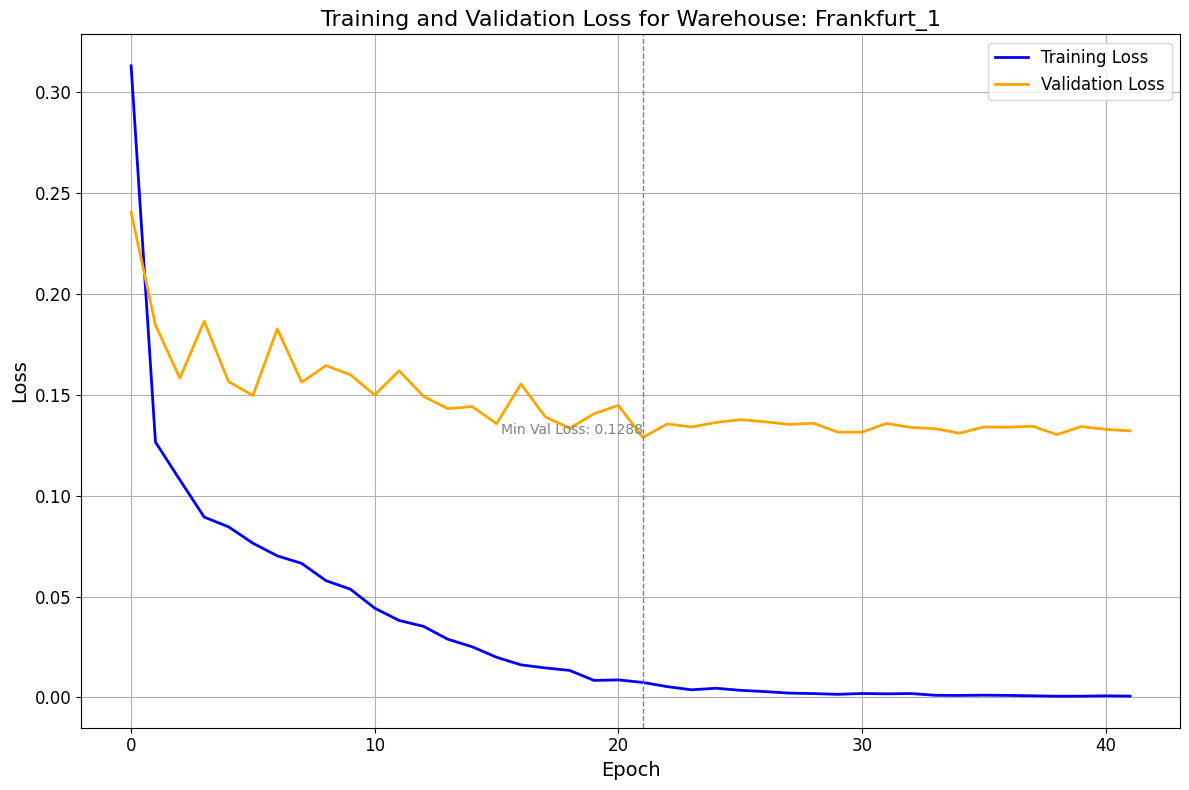

In [41]:
#### Training loop:

val_data = {}
training_features = {}

for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Training model for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse', 'date'])
    
    training_features[warehouse] = X_train_scaled.columns.tolist()

    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=True)
    
    # Create, compile the model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), lr=LEARNING_RATE, warehouse=warehouse)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
    ]
    
    # Save the test split of the dataset for each warehouse for future evaluation.
    val_data[warehouse] = (X_val, y_val)
    
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        #validation_split=0.2, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history, warehouse)

In [42]:
X_train_scaled.describe()

day_of_week_cos  day_of_week_sin  day_of_year_sin  day_of_year  \
count       629.000000       629.000000       629.000000   629.000000   
mean         -0.006221         0.000094        -0.088134     0.049715   
std           1.000869         0.999619         0.983508     1.020268   
min          -1.116623        -1.598109        -1.496832    -1.653016   
25%          -1.116623        -0.813537        -1.074280    -0.892233   
50%          -0.152291         0.444818        -0.059878     0.051522   
75%           1.050213         0.949380         0.925565     0.927866   
max           1.585377         1.229390         1.258534     1.842731   

       days_since_start     day_cos   month_cos  day_of_year_cos   month_sin  \
count        629.000000  629.000000  629.000000       629.000000  629.000000   
mean          -0.122938    0.003893    0.048366         0.026880   -0.077851   
std            0.929567    1.002144    1.014941         1.026962    0.993799   
min           -1.741156   -1.417594   -1.422893        -1.465885   -1.490129   
25%           -0.923349   -0.951425   -0.693753        -1.002746   -0.798827   
50%           -0.131098    0.138601    0.035387         0.106604   -0.107526   
75%            0.678190    0.934082    0.764527         1.010887    1.089843   
max            1.478960    1.400251    1.493667         1.464916    1.275077   

          day_sin  orders_lag_63  orders_lag_119  orders_lag_168  \
count  629.000000     629.000000      629.000000      629.000000   
mean     0.003191      -0.103461       -0.099757       -0.088915   
std      0.999348       0.941974        0.953777        0.970326   
min     -1.421194      -1.869745       -1.601668       -1.396137   
25%     -1.064319      -0.574570       -0.848692       -1.396137   
50%     -0.009291      -0.040402        0.106302        0.143168   
75%      1.045736       0.497425        0.547068        0.655042   
max      1.402611       3.043870        2.313806        2.529458   

       orders_lag_364  orders_rolling_mean_63  orders_rolling_std_63  \
count      629.000000              629.000000             629.000000   
mean        -0.116411               -0.111273              -0.121648   
std          0.933001                0.950172               0.931878   
min         -0.813520               -2.623352              -3.438621   
25%         -0.813520               -0.458635              -0.589710   
50%         -0.813520                0.061323              -0.145045   
75%          0.717307                0.308780               0.289236   
max          3.077161                1.646169               1.984477   

       orders_rolling_mean_168  orders_rolling_std_168  \
count               629.000000              629.000000   
mean                 -0.123649               -0.128601   
std                   0.928333                0.918872   
min                  -2.526326               -4.166099   
25%                  -0.846169               -0.431968   
50%                   0.068594               -0.195313   
75%                   0.479234                0.211224   
max                   1.504166                1.916540   

       orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
count               629.000000              629.000000     629.000000   
mean                 -0.116378               -0.100987       0.155803   
std                   0.941610                0.966353       0.362957   
min                  -2.683112               -4.776383       0.000000   
25%                  -0.665482               -0.397584       0.000000   
50%                  -0.100837                0.072849       0.000000   
75%                   0.624299                0.523361       0.000000   
max                   1.473368                1.298147       1.000000   

       day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
count     629.000000     629.000000     629.000000     629.000000   
mean        0.165342       0.171701       0.165

Save all scaler features into a single json scaler config file and save the scaler config so it can be loded for inference.

In [43]:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': training_features,
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

# MAPE Evaluation

## Visualize Predictions on the Training Data

Predicting for warehouse: Brno_1
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


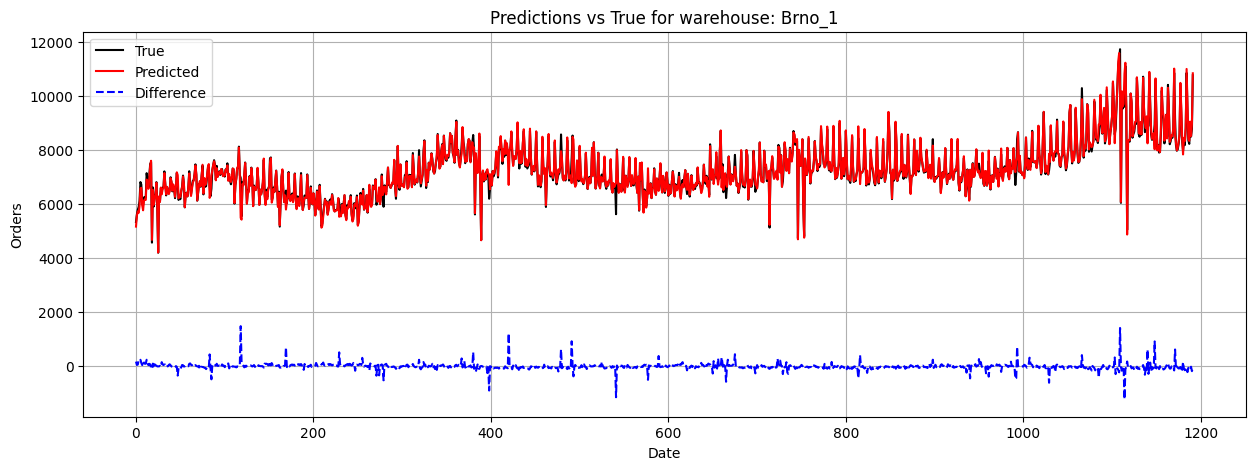


Mean Absolute Percentage Error on training data for Brno_1: 0.9432%
Predicting for warehouse: Budapest_1
Training mode - final shape: X: (1153, 1, 84), y: (1153,)
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


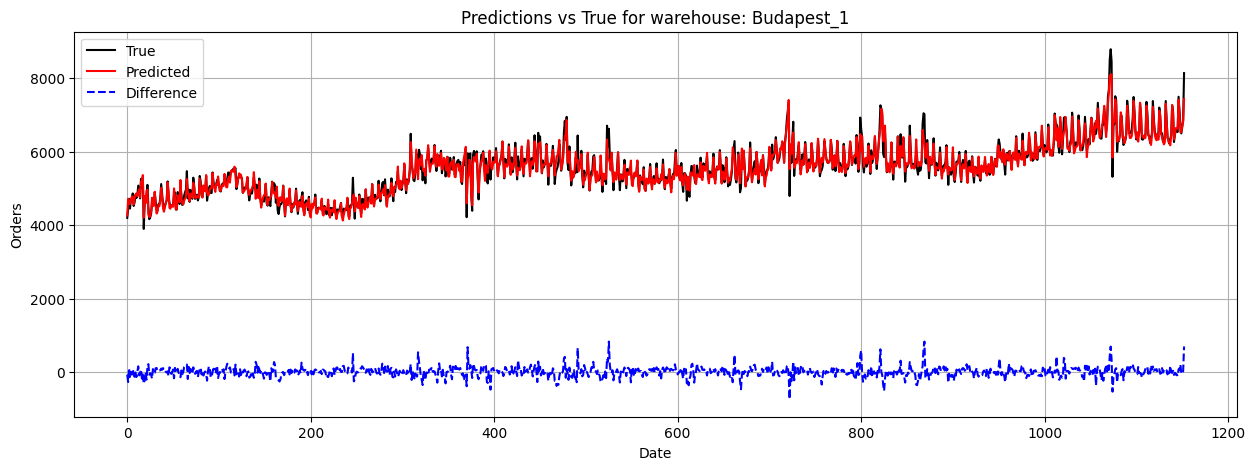


Mean Absolute Percentage Error on training data for Budapest_1: 1.7347%
Predicting for warehouse: Prague_1
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


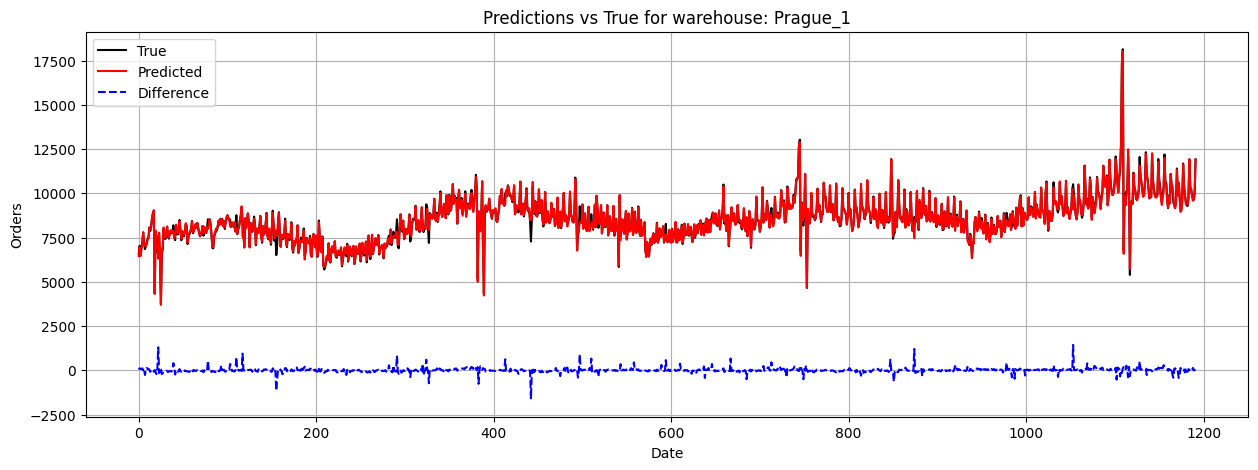


Mean Absolute Percentage Error on training data for Prague_1: 0.9051%
Predicting for warehouse: Prague_2
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


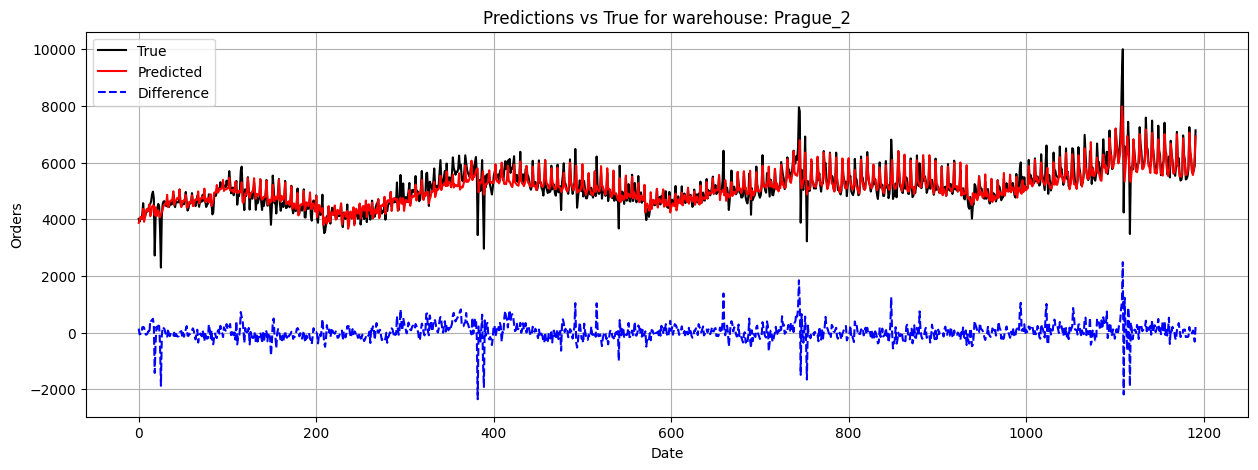


Mean Absolute Percentage Error on training data for Prague_2: 3.9547%
Predicting for warehouse: Prague_3
Training mode - final shape: X: (1192, 1, 84), y: (1192,)
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


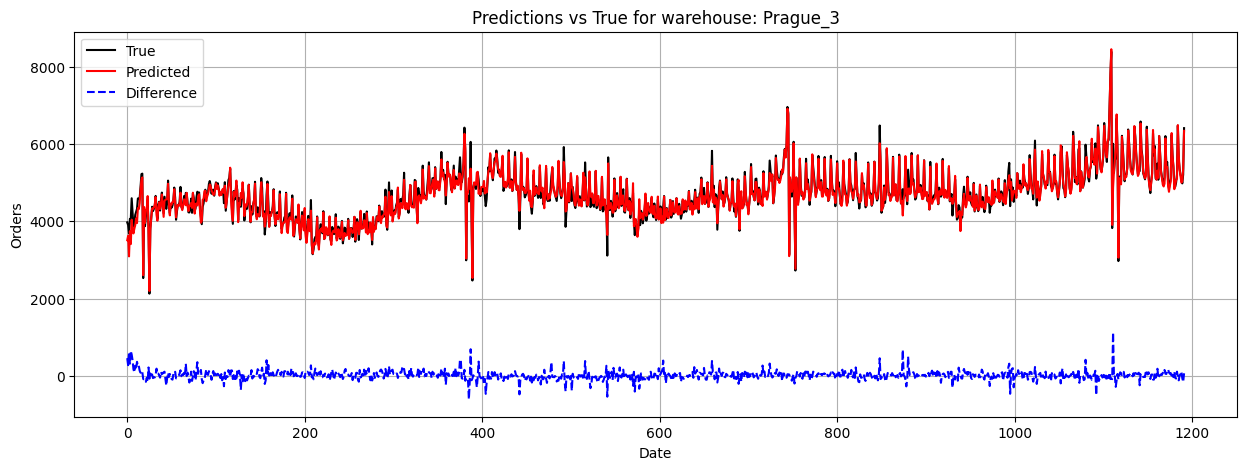


Mean Absolute Percentage Error on training data for Prague_3: 1.7495%
Predicting for warehouse: Munich_1
Training mode - final shape: X: (784, 1, 83), y: (784,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


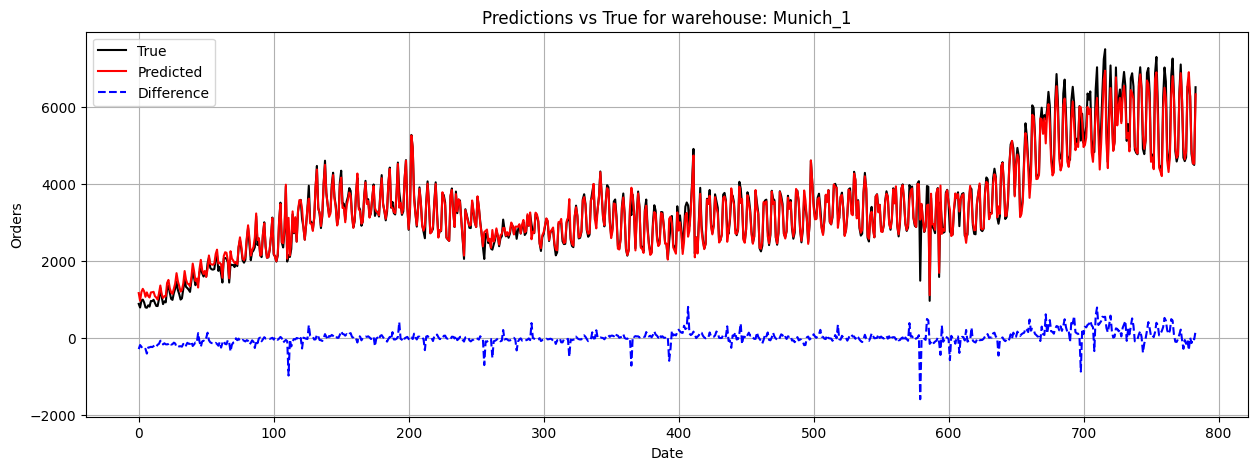


Mean Absolute Percentage Error on training data for Munich_1: 3.8239%
Predicting for warehouse: Frankfurt_1
Training mode - final shape: X: (628, 1, 81), y: (628,)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


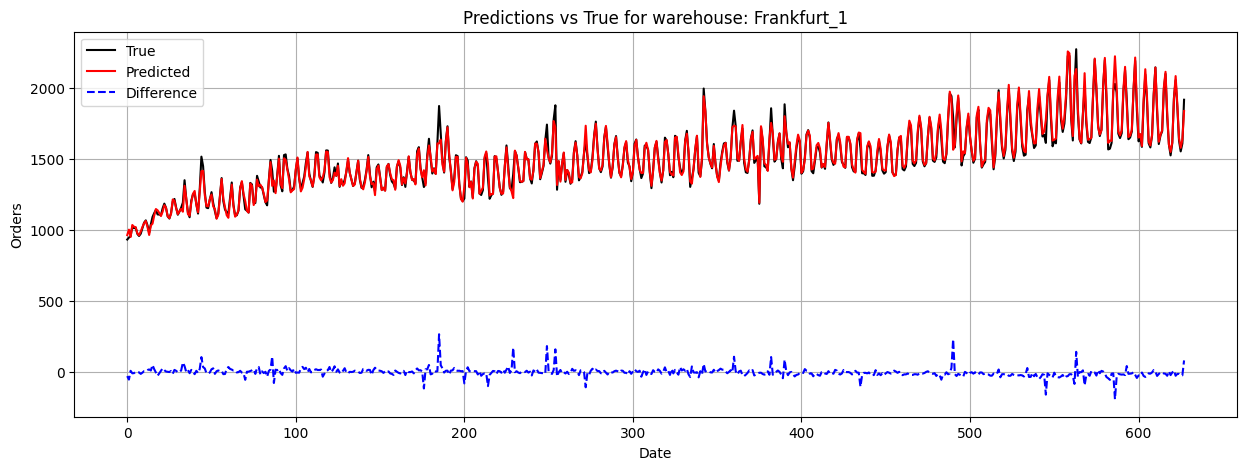


Mean Absolute Percentage Error on training data for Frankfurt_1: 1.2060%

MAPE training scores: 
Brno_1: 0.9432%
Budapest_1: 1.7347%
Prague_1: 0.9051%
Prague_2: 3.9547%
Prague_3: 1.7495%
Munich_1: 3.8239%
Frankfurt_1: 1.2060%

Mean training MAPE: 2.0453%


In [44]:
#tf.keras.config.enable_unsafe_deserialization()

# Load scalers

# Initialize a list to store MAPE scores
mape_scores = []

# Loop through each warehouse and calculate MAPE
for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Predicting for warehouse: {warehouse}")
    y_scaler = joblib.load(f'y_scaler_{warehouse}.joblib')
    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse', 'date'])
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)

    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')

    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq = y_seq.reshape(-1, 1)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)

    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'\nMean Absolute Percentage Error on training data for {warehouse}: {mape:.4f}%')

# Print MAPE scores
print("\nMAPE training scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean training MAPE: {np.mean(mape_scores):.4f}%")

## Visualize Predictions on the Validation Data

Predicting for warehouse: Brno_1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


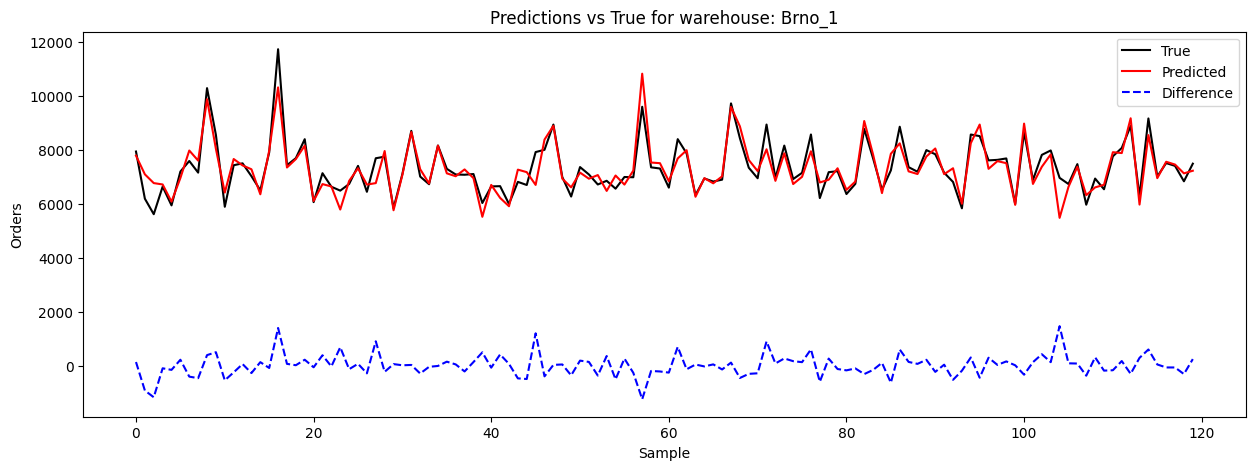


Mean Absolute Percentage Error on validation data for Brno_1: 3.9717%
Predicting for warehouse: Budapest_1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


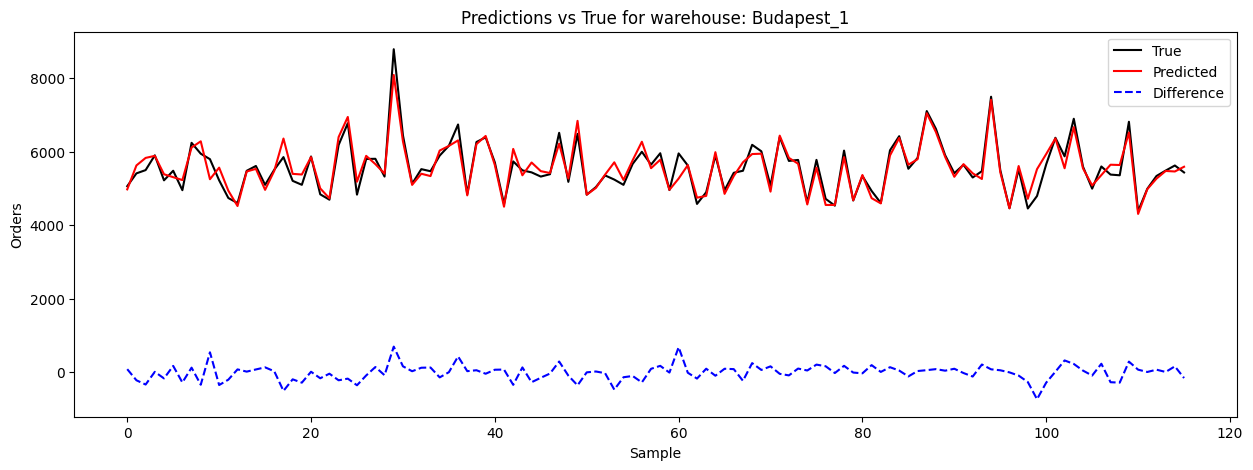


Mean Absolute Percentage Error on validation data for Budapest_1: 2.7799%
Predicting for warehouse: Prague_1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


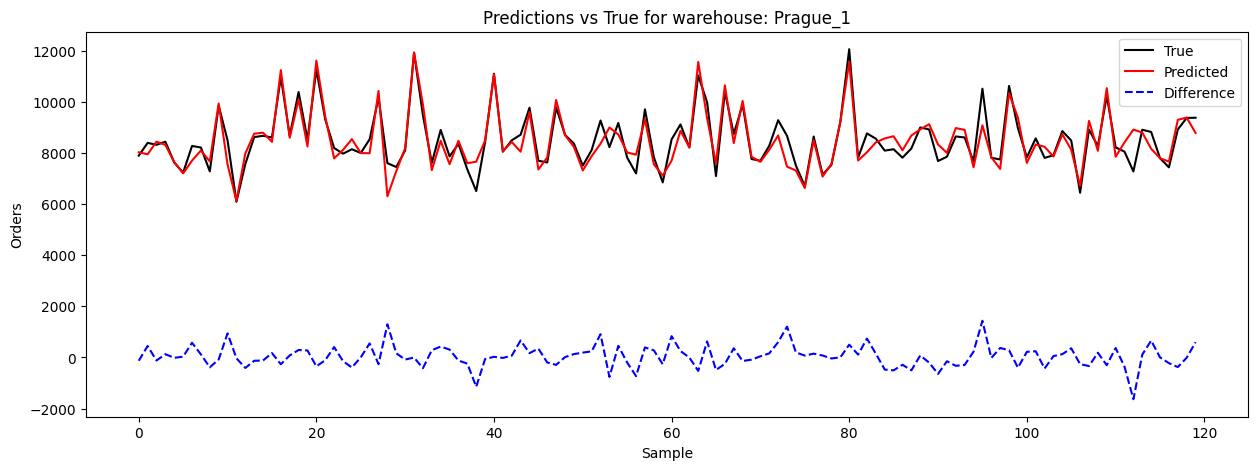


Mean Absolute Percentage Error on validation data for Prague_1: 3.8184%
Predicting for warehouse: Prague_2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


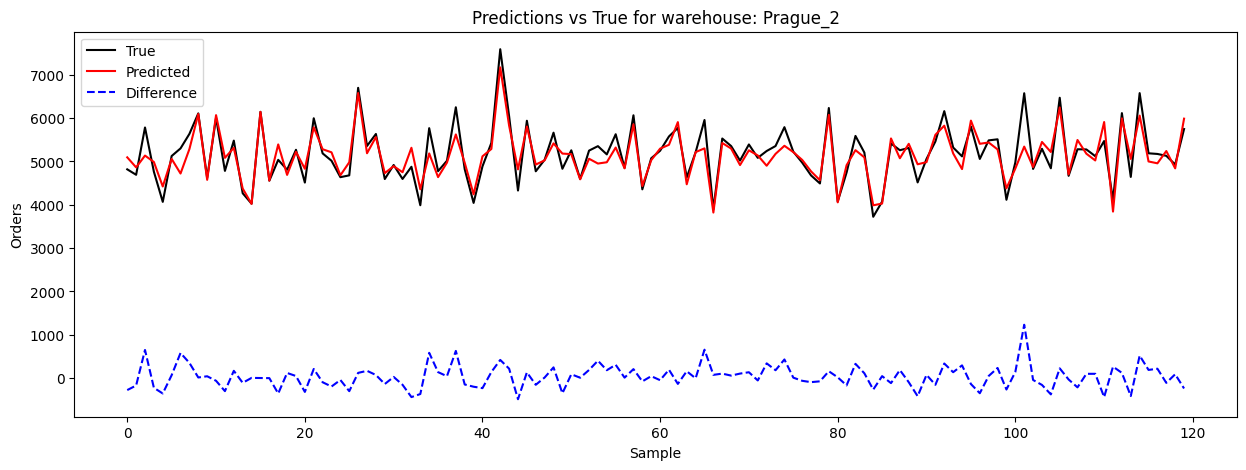


Mean Absolute Percentage Error on validation data for Prague_2: 3.8671%
Predicting for warehouse: Prague_3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


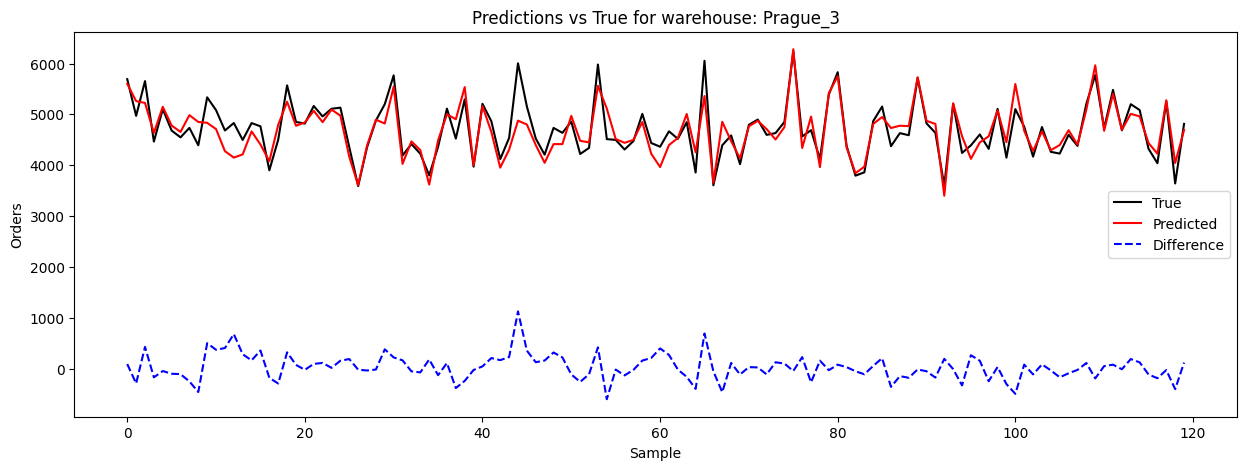


Mean Absolute Percentage Error on validation data for Prague_3: 4.0009%
Predicting for warehouse: Munich_1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


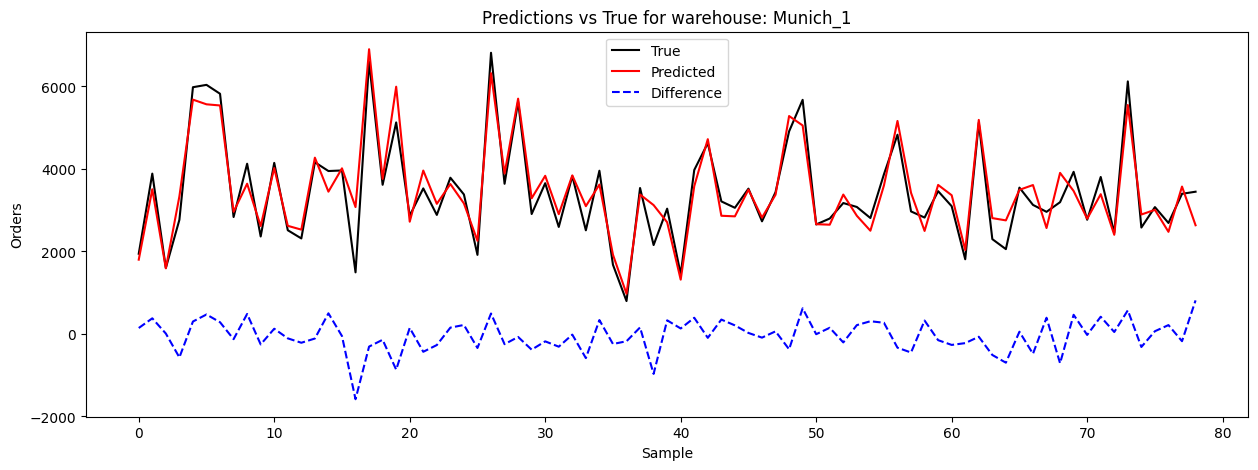


Mean Absolute Percentage Error on validation data for Munich_1: 10.5280%
Predicting for warehouse: Frankfurt_1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


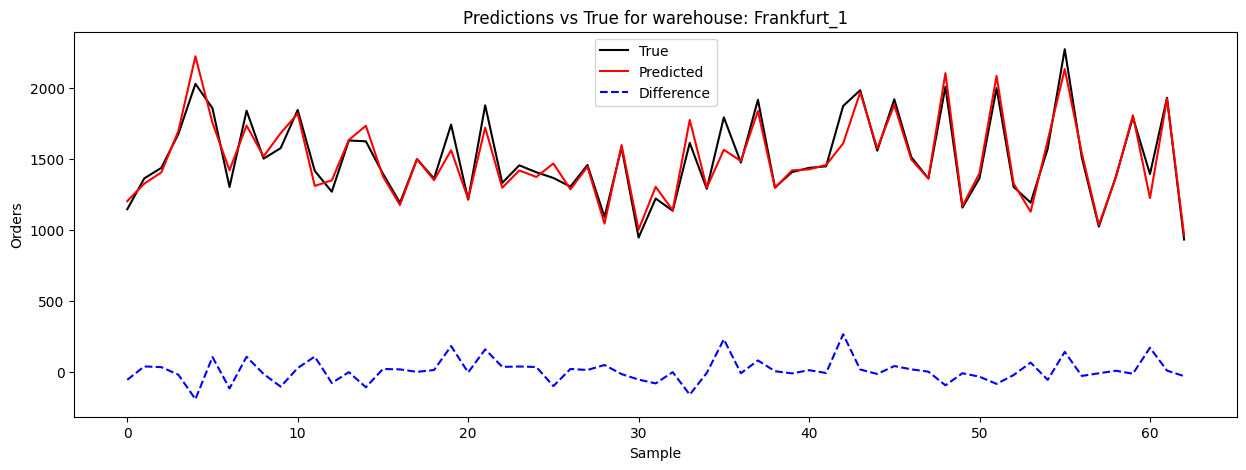


Mean Absolute Percentage Error on validation data for Frankfurt_1: 3.6404%

MAPE validation scores: 
Brno_1: 3.9717%
Budapest_1: 2.7799%
Prague_1: 3.8184%
Prague_2: 3.8671%
Prague_3: 4.0009%
Munich_1: 10.5280%
Frankfurt_1: 3.6404%

Mean validation MAPE: 4.6581%


In [45]:
mape_scores = []

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    y_scaler = joblib.load(f'y_scaler_{warehouse}.joblib')
    
    # Load the validation data for the current warehouse
    X_val, y_val = val_data[warehouse]
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
    
    # Predict
    predictions = model.predict(X_val)
    predictions = y_scaler.inverse_transform(predictions)
    y_val = y_val.reshape(-1, 1)
    y_val_unscaled = y_scaler.inverse_transform(y_val)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_val_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Sample')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on validation data for {warehouse}: {mape:.4f}%')

print("\nMAPE validation scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean validation MAPE: {np.mean(mape_scores):.4f}%")


## Inference and Visualisation on the TEST Data:

Here we deploy our trained models and run inference on the test data from the challenge. The test data are already preprocessed from the previous step, so we only load them and create LSTM sequences, then predict. If we wanted to take raw test data, we would only need to utilize the "process_data" function from the above section first.

This sequence function is not using the TimeseriesGenerator, because I could not figure out how to use it so it would utilize all the test data rows, there were always leftovers.
This function is creating sequences for each row and when it does not have enough data, it is padding the sequence with the first row of the sequence.

Function that that predicts the test data on multiple timelines - splitting the data for each warehouse, using multiple models.

In [46]:
def predict_multiple(data, time_steps, warehouses_trained, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouses_trained:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue
        model_data = warehouses_trained[warehouse]
        model = model_data['model']
        y_scaler = model_data['y_scaler']
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features[warehouse])
    

        sequences = create_sequences(wh_data, None, time_steps)
        print(f"{warehouse}: ")
        print(len(sequences))
        # Predict on all sequences
        preds = model.predict(sequences)
        preds_rescaled = y_scaler.inverse_transform(preds)

        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)

        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)

        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()

        wh_submission_data['predicted_orders'] = wh_predictions

        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)

    submission_df.dropna(inplace=True)

    return np.array(predictions), submission_df

Load the saved models and scalers for each warehouse. This is optional and a conscious choise to use and is a part of end-to-end approach with potential deployment in mind.

In [47]:
def load_models_and_scalers(warehouses):
    warehouse_models_and_scalers = {}

    for wh in warehouses:
        try:
            model = tf.keras.models.load_model(f'model_{wh}.keras')
            x_scaler = joblib.load(f'x_scaler_{wh}.joblib')
            y_scaler = joblib.load(f'y_scaler_{wh}.joblib')
            encoder = joblib.load(f'onehot_scaler_{wh}.joblib')
            
            warehouse_models_and_scalers[wh] = {
                'model': model,
                'x_scaler': x_scaler,
                'y_scaler': y_scaler,
                'encoder': encoder
            }
        except Exception as e:
            print(f"Error loading model or scaler for warehouse {wh}: {str(e)}")

    return warehouse_models_and_scalers

Here we load the scaler configuration and other metadata from the training stage

In [48]:
scaler_config = joblib.load('scaler_config_mt.joblib') # load the scaler config

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']    # training features dictionary
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'quarter', 'month', 'day', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 10


 Load the saved preprocessed training data

In [49]:
dataframe_raw = pd.read_csv("/kaggle/working/test_proc_mt.csv")
dataframe_raw['date'] = pd.to_datetime(dataframe_raw['date'])
dataframe = dataframe_raw.sort_values(by=['date', 'warehouse'])
print(f"Rows: {len(dataframe)}")

Rows: 410


In [50]:
dataframe.head()

Unnamed: 0  day_of_week_cos  day_of_week_sin  day_of_year_sin  \
0          7327        -1.276522         0.610710         1.248728   
63         7328        -1.263646         0.594986         1.265573   
360        7329        -1.116623         0.444818         1.198251   
310        7330        -1.116435         0.449890         1.326481   
121        7331        -1.276522         0.610710         1.248728   

     day_of_year  days_since_start   day_cos  month_cos  day_of_year_cos  \
0      -0.920721          1.560136 -1.386386  -0.038252         0.344895   
63     -0.925428          1.562883 -1.377103  -0.044154         0.342750   
360    -0.959644          1.474701 -1.386806   0.035387         0.428273   
310    -1.003843          1.523286 -1.382144  -0.107224         0.314889   
121    -0.920721          1.560136 -1.386386  -0.038252         0.344895   

     month_sin   day_sin  orders_lag_63  orders_lag_119  orders_lag_168  \
0     1.305304  0.277013       1.835345        1.451921        1.848952   
63    1.316030  0.271782       1.394969        1.067722        1.549692   
360   1.275077  0.285877       3.043870        0.267916        1.258979   
310   1.369836  0.292999       2.079619        2.579905        0.063203   
121   1.305304  0.277013       1.433762        0.918219        1.727821   

     orders_lag_364  orders_rolling_mean_63  orders_rolling_std_63  \
0         -0.157759                2.100820               1.252092   
63         2.008811                1.826652               0.650338   
360        1.062051                1.487272               1.570490   
310        0.478750                1.943578               1.787132   
121        0.773868                1.791949               0.207895   

     orders_rolling_mean_168  orders_rolling_std_168  orders_rolling_mean_364  \
0                   2.340596                2.162843                 2.095920   
63                  1.966348                1.481740                 1.734140   
360                 1.495914                1.714975                 1.463593   
310                 1.958506                1.749259                 1.645267   
121                 2.032432                1.845868                 1.746096   

     orders_rolling_std_364  day_of_week_0  day_of_week_1  day_of_week_2  \
0                  2.441504            0.0            0.0            0.0   
63                 1.660039            0.0            0.0            0.0   
360                1.261520            0.0            0.0            0.0   
310                1.801937            0.0            0.0            0.0   
121                1.759105            0.0            0.0            0.0   

     day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  quarter_1  \
0              1.0            0.0            0.0            0.0        1.0   
63             1.0            0.0            0.0            0.0        1.0   
360            1.0            0.0            0.0            0.0        1.0   
310            1.0            0.0            0.0            0.0        1.0   
121            1.0            0.0            0.0            0.0        1.0   

     quarter_2  quarter_3  quarter_4  month_1  month_2  month_3  month_4  \
0          0.0        0.0        0.0      0.0      0.0      1.0      0.0   
63         0.0        0.0        0.0      0.0      0.0      1.0      0.0   
360        0.0        0.0        0.0      0.0      0.0      1.0      0.0   
310        0.0        0.0        0.0      0.0      0.0      1.0      0.0   
121        0.0        0.0        0.0      0.0      0.0      1.0      0.0   

     month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
0        0.0      0.0      0.0      0.0      0.0       0.0       0.0   
63       0.0      0.0      0.0      0.0      0.0       0.0       0.0   
360      0.0      0.0      0.0      0.0      0.0       0.0       0.0   
310      0.0      0.0      0.0      0.0      0.0       0.0       0.0   
121      0.0      0.0    

## Load models and predict the test dataset

In [51]:
warehouse_lengths = test_df.groupby('warehouse').size()

for warehouse, length in warehouse_lengths.items():
    print(f"{warehouse}: {length}")

Brno_1: 61
Budapest_1: 57
Frankfurt_1: 48
Munich_1: 48
Prague_1: 61
Prague_2: 61
Prague_3: 61


In [52]:
warehouse_models = load_models_and_scalers(warehouses)
predictions, submission_df = predict_multiple(dataframe, TIME_STEPS, warehouse_models, training_features)

Inference mode - final shape: X: (62, 1, 84)
Brno_1: 
62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Inference mode - final shape: X: (57, 1, 84)
Budapest_1: 
57
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Inference mode - final shape: X: (49, 1, 81)
Frankfurt_1: 
49
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Inference mode - final shape: X: (49, 1, 83)
Munich_1: 
49
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Inference mode - final shape: X: (62, 1, 84)
Prague_1: 
62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Inference mode - final shape: X: (62, 1, 84)
Prague_2: 
62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Inference mode - final shape: X: (62, 1, 84)
Prague_3: 
62
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [53]:
submission_df = submission_df.rename(columns={"predicted_orders": "orders"})

submission_df = submission_df[submission_df['date'].isin(test_df_raw['date'])]

submission_export = submission_df[["id", "orders"]]



In [54]:
print(len(processed_test_df))
print(len(submission_df))
print(sum(submission_df.isna().sum()))

410
397
0


In [55]:
submission_df.head()

Unnamed: 0  day_of_week_cos  day_of_week_sin  day_of_year_sin  day_of_year  \
2        7340        -0.316381        -1.380270         1.262194    -0.902247   
3        7347         0.880894        -1.107379         1.268320    -0.893010   
4        7352         1.413732        -0.002469         1.274038    -0.883774   
5        7359         0.880894         1.102442         1.279348    -0.874537   
6        7366        -0.316381         1.375332         1.284247    -0.865300   

   days_since_start   day_cos  month_cos  day_of_year_cos  month_sin  \
2          1.565646 -1.386386  -0.038252         0.297800   1.305304   
3          1.568401 -1.295574  -0.038252         0.274085   1.305304   
4          1.571156 -1.148638  -0.038252         0.250267   1.305304   
5          1.573911 -0.952000  -0.038252         0.226354   1.305304   
6          1.576666 -0.714253  -0.038252         0.202353   1.305304   

    day_sin  orders_lag_63  orders_lag_119  orders_lag_168  orders_lag_364  \
2 -0.314799       2.804617        2.606232        1.398309        1.615840   
3 -0.597773       1.441314        0.947198        0.142462        0.895551   
4 -0.855447       1.338066        1.304758        0.456424        0.701163   
5 -1.076559       1.803738        1.133451        0.372520        0.404308   
6 -1.251447       1.402333        0.957546        0.114043       -0.058305   

   orders_rolling_mean_63  orders_rolling_std_63  orders_rolling_mean_168  \
2                2.083668               1.259645                 2.359203   
3                2.090733               1.290591                 2.374042   
4                2.100098               1.317849                 2.386909   
5                2.100312               1.356950                 2.400511   
6                2.108835               1.388427                 2.416074   

   orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  \
2                2.242167                 2.120180                2.512918   
3                2.213226                 2.123573                2.520395   
4                2.196324                 2.127798                2.526490   
5                2.175368                 2.133291                2.529863   
6                2.142144                 2.140759                2.527543   

   day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            1.0            0.0            0.0            0.0            0.0   
5            0.0            1.0            0.0            0.0            0.0   
6            0.0            0.0            1.0            0.0            0.0   

   day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  quarter_4  \
2            1.0            0.0        1.0        0.0        0.0        0.0   
3            0.0            1.0        1.0        0.0        0.0        0.0   
4            0.0            0.0        1.0        0.0        0.0        0.0   
5            0.0            0.0        1.0        0.0        0.0        0.0   
6            0.0            0.0        1.0        0.0        0.0        0.0   

   month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
5      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
6      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   

   month_9  month_10  month_11  month_12  day_1  day_2  day_3  day_4  day_5  \
2      0.0       0.0       0.0       0.0    0.0    0.0    0.0    0.0    0.0   
3      0.0       0.0       0.0       0.0    0.0    0.0    0.0    0.0    0.0   
4      0.0       0.0      

In [56]:
submission_export.to_csv("/kaggle/working/submission.csv", index=False)

## Visualise the Test Data Predictions
Visualise the predictions for 2 months of the test data with the actual data from previous year to see how the predictions fit.

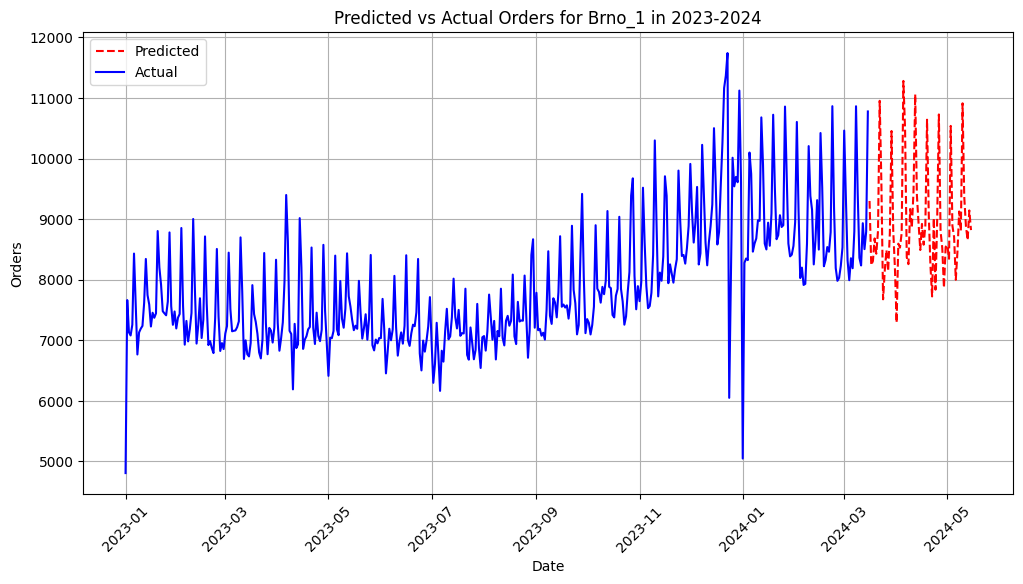

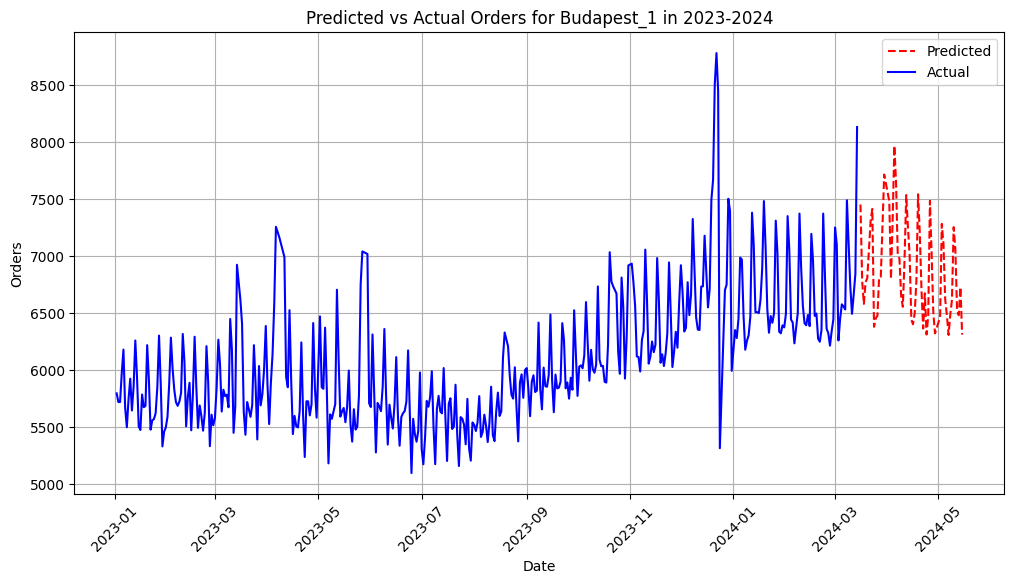

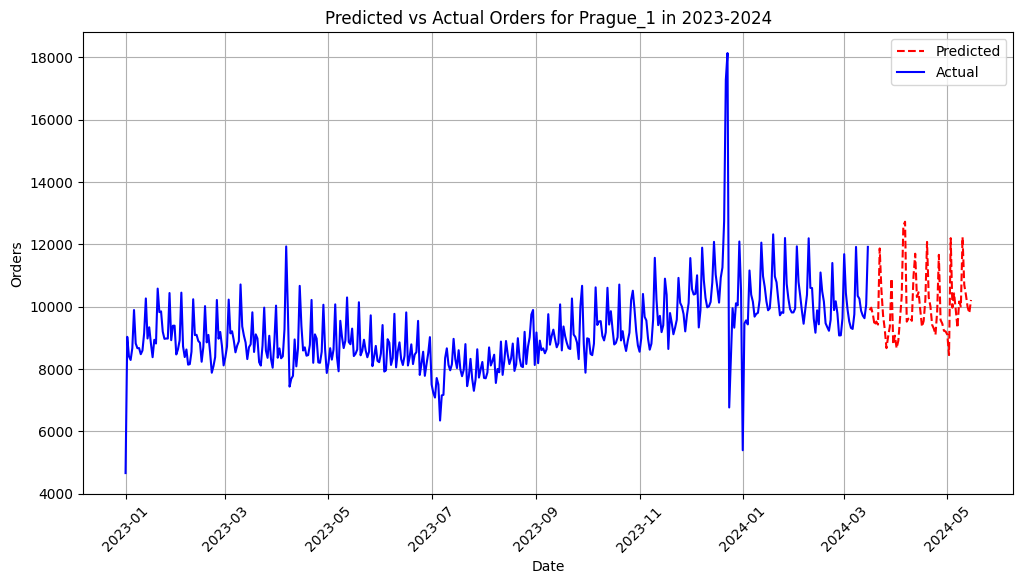

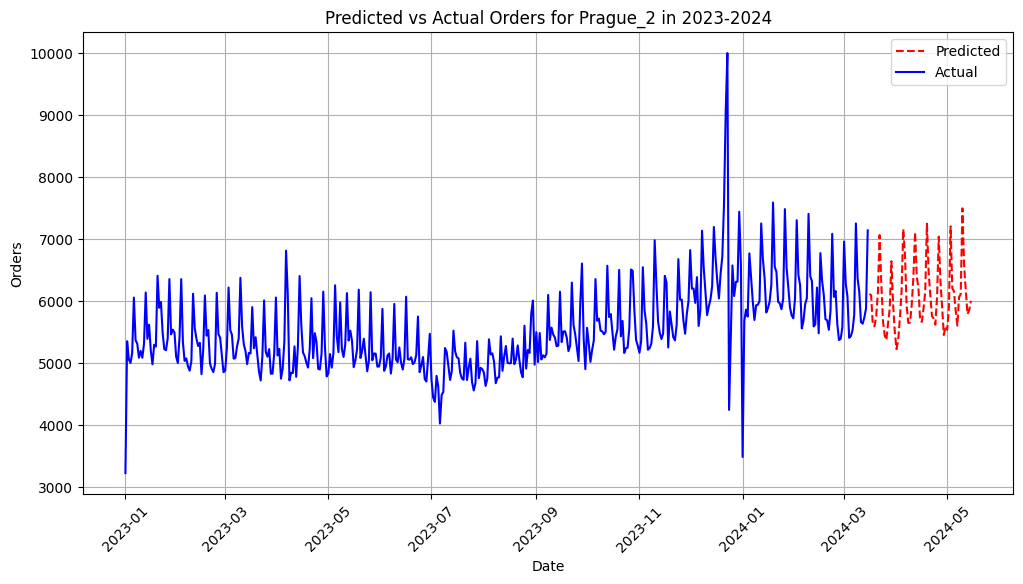

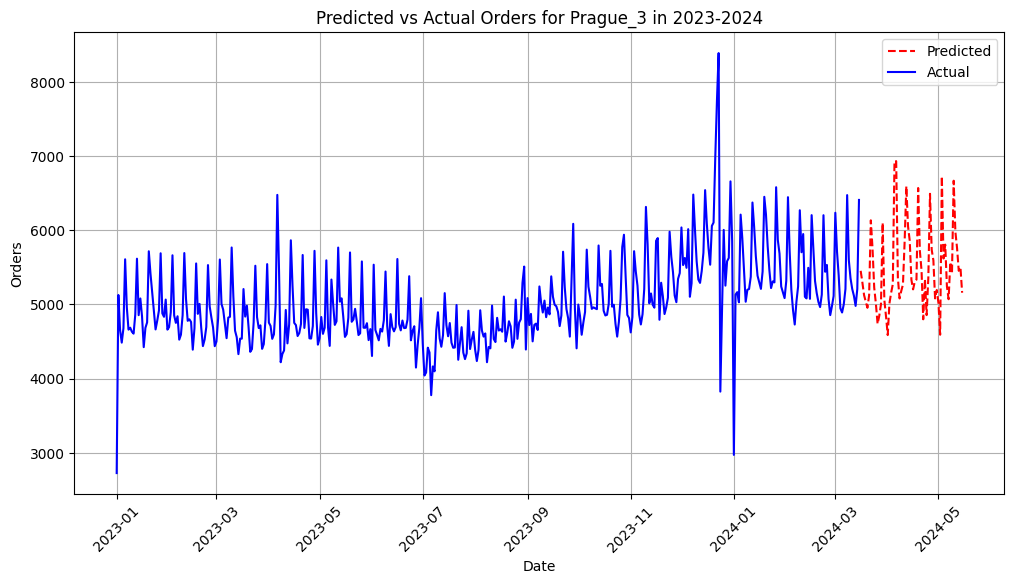

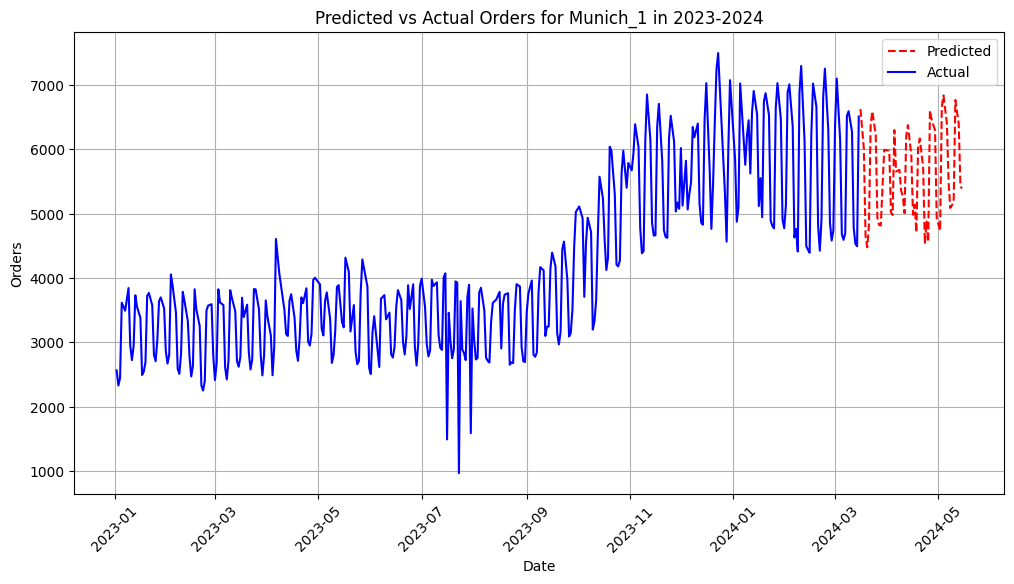

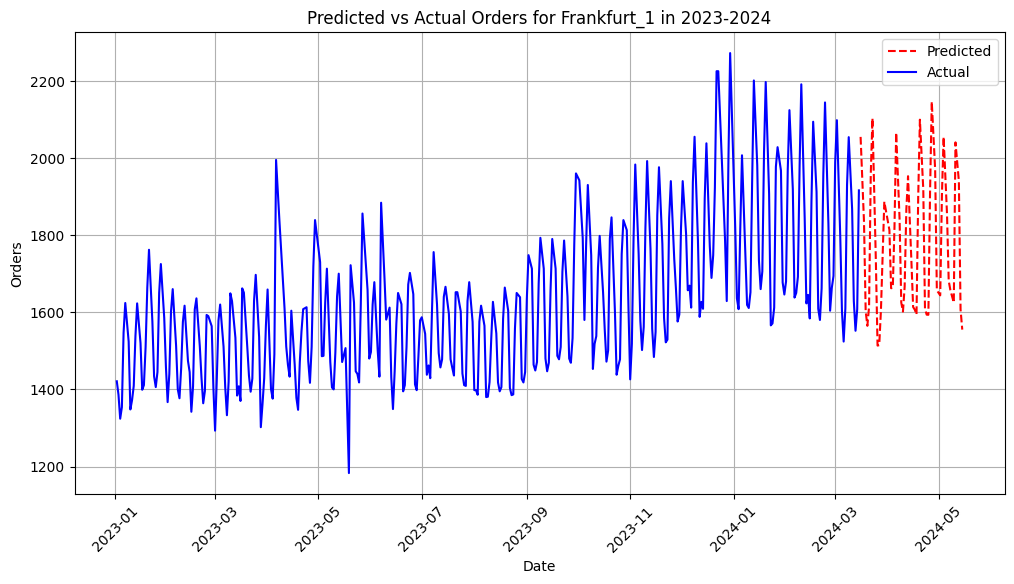

Predictions complete. Submission file and plots created.


In [57]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]

for wh in warehouses:

    wh_df_pred = submission_df[submission_df['warehouse'] == wh]
    wh_df_pred = wh_df_pred.sort_values(by=['date'])
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    wh_df_last_year = wh_df_last_year.sort_values(by=['date'])
    
    # Plot data (training data from 2023)

    plt.figure(figsize=(12, 6))
    
    plt.plot(wh_df_pred.date, wh_df_pred['orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")

In [58]:
city = "Prague_1"
submission_single_df = submission_df[submission_df['date'].isin(test_df_raw['date'])]
submission_single_df = submission_single_df[submission_single_df.warehouse == city]
submission_single_df = submission_single_df[["id", "orders", "date", "warehouse"]]
submission_single_df.to_csv(f"/kaggle/working/submission_{city}.csv", index=False)



In [59]:
submission_single_df.tail()

id        orders       date warehouse
179  Prague_1_2024-05-11  10702.122070 2024-05-11  Prague_1
180  Prague_1_2024-05-12  10372.492188 2024-05-12  Prague_1
181  Prague_1_2024-05-13   9984.829102 2024-05-13  Prague_1
182  Prague_1_2024-05-14   9792.644531 2024-05-14  Prague_1
183  Prague_1_2024-05-15  10213.045898 2024-05-15  Prague_1

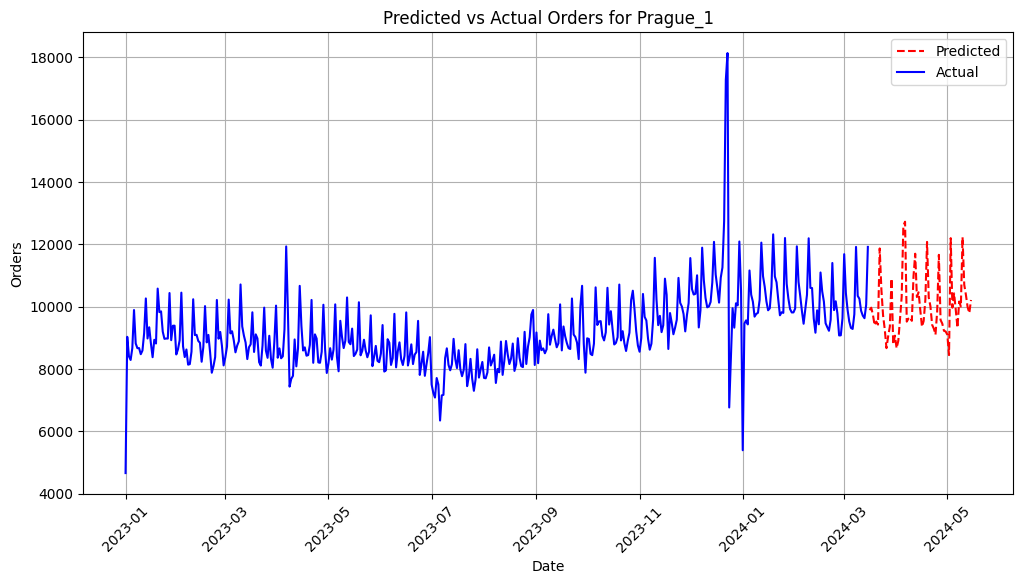

In [60]:

train_df_raw = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

#last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]


wh_df_pred = submission_single_df[submission_single_df['warehouse'] == city]
wh_df_pred = wh_df_pred.sort_values(by=['date'])
wh_df_last_year = last_year_data[last_year_data['warehouse'] == city]
wh_df_last_year = wh_df_last_year.sort_values(by=['date'])


plt.figure(figsize=(12, 6))

plt.plot(wh_df_pred.date, wh_df_pred['orders'], label='Predicted',  linestyle='--', color='red')

plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

plt.title(f'Predicted vs Actual Orders for {city}')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(f'prediction_plot_{wh}.png')
plt.show()
plt.close()

# Testing ground:

In [61]:
x_val, y_val = val_data["Prague_1"]
x_val.shape

(120, 1, 84)

In [62]:
x_val_test = dataframe[dataframe.warehouse == "Prague_1"]
x_val_test_reindex = x_val_test.reindex(columns=training_features["Prague_1"])
x_test_sequences = create_sequences(x_val_test_reindex, None, TIME_STEPS)
x_test_sequences.shape

Inference mode - final shape: X: (62, 1, 84)


(62, 1, 84)

In [63]:
array1_flat = x_val.reshape(-1, x_val.shape[-1])
array2_flat = x_test_sequences.reshape(-1, x_test_sequences.shape[-1])

In [64]:
df1_val = pd.DataFrame(array1_flat)
df2_sub = pd.DataFrame(array2_flat)

In [65]:
df2_sub.head()

0         1         2         3         4         5         6   \
0 -1.276522  0.610710  1.248728 -0.920721  1.560136 -1.386386 -0.038252   
1 -1.276522 -0.615648  1.255663 -0.911484  1.562891 -1.417104 -0.038252   
2 -0.316381 -1.380270  1.262194 -0.902247  1.565646 -1.386386 -0.038252   
3  0.880894 -1.107379  1.268320 -0.893010  1.568401 -1.295574 -0.038252   
4  1.413732 -0.002469  1.274038 -0.883774  1.571156 -1.148638 -0.038252   

         7         8         9         10        11        12        13  \
0  0.344895  1.305304  0.277013  1.433762  0.918219  1.727821  0.773868   
1  0.321406  1.305304 -0.018893  2.921842  2.161687  2.333965  0.862273   
2  0.297800  1.305304 -0.314799  2.048122  1.727764  0.602922  1.817050   
3  0.274085  1.305304 -0.597773  1.772552  0.281910 -0.258882  0.632419   
4  0.250267  1.305304 -0.855447  1.394858  1.242204  0.766543  1.158198   

         14        15        16        17        18        19   20   21   22  \
0  1.791949  0.207895  2.032432  1.845868  1.746096  1.759105  0.0  0.0  0.0   
1  1.789649  0.191803  2.041860  1.878435  1.761380  1.800823  0.0  0.0  0.0   
2  1.776971  0.195586  2.051230  1.880227  1.758635  1.808665  0.0  0.0  0.0   
3  1.769773  0.212835  2.067794  1.848467  1.762134  1.815368  0.0  0.0  0.0   
4  1.770549  0.236589  2.076081  1.853936  1.762867  1.825052  1.0  0.0  0.0   

    23   24   25   26   27   28   29   30   31   32   33   34   35   36   37  \
0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

    38   39   40   41   42   43   44   45   46   47   48   49   50   51   52  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    53   54   55   56   57   58   59   60   61   62   63   64   65   66   67  \
0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    68   69   70   71   72   73   74   75   76   77   78   79   80   81   82  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

    83  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [66]:
print(X_train_scaled.shape)
X_train_scaled.head()

(629, 81)


day_of_week_cos  day_of_week_sin  day_of_year_sin  day_of_year  \
2334        -1.116623        -0.813537         0.909951    -1.200398   
2341        -0.152291        -1.598109         0.925565    -1.190768   
2365        -0.152291         1.229390         0.984882    -1.152248   
2372        -1.116623         0.444818         0.998905    -1.142617   
2379        -1.116623        -0.813537         1.012595    -1.132987   

      days_since_start   day_cos  month_cos  day_of_year_cos  month_sin  \
2334         -1.741156 -1.148514   0.764527         0.973786   1.089843   
2341         -1.736897 -0.951425   0.764527         0.954799   1.089843   
2365         -1.719859  0.138601   0.764527         0.876079   1.089843   
2372         -1.715600  0.426710   0.764527         0.855735   1.089843   
2379         -1.711340  0.695790   0.764527         0.835137   1.089843   

       day_sin  orders_lag_63  orders_lag_119  orders_lag_168  orders_lag_364  \
2334 -0.843758      -1.869745       -1.601668       -1.396137        -0.81352   
2341 -1.064319      -1.869745       -1.601668       -1.396137        -0.81352   
2365 -1.421194      -1.869745       -1.601668       -1.396137        -0.81352   
2372 -1.359487      -1.869745       -1.601668       -1.396137        -0.81352   
2379 -1.238770      -1.869745       -1.601668       -1.396137        -0.81352   

      orders_rolling_mean_63  orders_rolling_std_63  orders_rolling_mean_168  \
2334               -2.623352              -3.438621                -2.526326   
2341               -2.618628              -3.438621                -2.521321   
2365               -2.595007              -3.250454                -2.496296   
2372               -2.571387              -3.158817                -2.471272   
2379               -2.493910              -2.491371                -2.389192   

      orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  \
2334               -4.166099                -2.683112               -4.776383   
2341               -4.166099                -2.677102               -4.776383   
2365               -3.949208                -2.647051               -4.548438   
2372               -3.843582                -2.617000               -4.437430   
2379               -3.074249                -2.518433               -3.628889   

      day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
2334            0.0            0.0            0.0            0.0   
2341            0.0            0.0            0.0            0.0   
2365            0.0            0.0            1.0            0.0   
2372            0.0            0.0            0.0            1.0   
2379            0.0            0.0            0.0            0.0   

      day_of_week_4  day_of_week_5  quarter_1  quarter_2  quarter_3  \
2334            1.0            0.0        1.0        0.0        0.0   
2341            0.0            1.0        1.0        0.0        0.0   
2365            0.0            0.0        1.0        0.0        0.0   
2372            0.0            0.0        1.0        0.0        0.0   
2379            1.0            0.0        1.0        0.0        0.0   

      quarter_4  month_1  month_2  month_3  month_4  month_5  month_6  \
2334        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2341        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2365        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2372        0.0      0.0      1.0      0.0      0.0      0.0      0.0   
2379        0.0      0.0      1.0      0.0      0.0      0.0      0.0   

      month_7  month_8  month_9  month_10  month_11  month_12  day_1  day_2  \
2334      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0   
2341      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0   
2365      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0   
2372      0.0      0.0      0.0       0.0       0.0       0.0    0.0    0.0 

In [67]:

df1_val.head()

0         1         2         3         4         5         6   \
0 -0.316381  1.375332 -0.977661  0.437081  0.959560 -0.445787 -0.748714   
1 -0.316381 -1.380270  0.220296 -0.043230 -0.189249 -1.148638 -1.459177   
2 -0.316381 -1.380270 -1.480281  1.055942  0.138588 -1.417104  0.672210   
3 -0.316381 -1.380270 -1.433271  0.732656  0.042165 -0.714253 -0.038252   
4  1.413732 -0.002469 -1.088160  0.492501 -0.029463 -1.417104 -0.748714   

         7         8         9         10        11        12        13  \
0 -1.193556 -1.339668  1.334680 -0.260186 -0.182829 -0.063651 -0.458222   
1 -1.456601 -0.112133 -0.855447 -1.356794  0.667527 -3.577800 -0.255356   
2  0.274085 -1.339668 -0.018893 -1.069066 -0.530966 -0.180789  1.331286   
3 -0.569216 -1.529569  1.213661 -1.108781 -0.477663 -0.094330 -0.674117   
4 -1.097287 -1.339668 -0.018893  0.328238 -0.299430  1.297384 -1.277134   

         14        15        16        17        18        19   20   21   22  \
0 -0.427342 -0.491543  0.177606 -0.548535  0.649519 -0.464135  0.0  0.0  1.0   
1 -0.236820 -0.322960  0.456570 -0.511630 -0.023369  1.253332  0.0  0.0  0.0   
2 -0.307099 -0.692426 -0.473821 -0.988300  0.500182 -0.248345  0.0  0.0  0.0   
3 -0.847252 -1.286317 -0.447591 -0.746911  0.375398 -0.078192  0.0  0.0  0.0   
4 -0.908180 -0.656848 -0.269179 -0.471714  0.250762  0.345799  1.0  0.0  0.0   

    23   24   25   26   27   28   29   30   31   32   33   34   35   36   37  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    38   39   40   41   42   43   44   45   46   47   48   49   50   51   52  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    53   54   55   56   57   58   59   60   61   62   63   64   65   66   67  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    68   69   70   71   72   73   74   75   76   77   78   79   80   81   82  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

    83  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [68]:
print(processed_train_data_dict["Prague_1"][0].shape)
processed_train_data_dict["Prague_1"][0].head()


(1193, 87)


day_of_week_cos  day_of_week_sin  day_of_year_sin  day_of_year  \
2         -0.316381        -1.380270        -0.697024     1.536253   
7          0.880894        -1.107379        -0.674773     1.545490   
12         1.413732        -0.002469        -0.652354     1.554726   
17         0.880894         1.102442        -0.629774     1.563963   
22        -0.316381         1.375332        -0.607038     1.573200   

    days_since_start   day_cos  month_cos  day_of_year_cos  month_sin  \
2          -1.732015  0.691449   1.382673         1.221956  -0.112133   
7          -1.729260  0.422984   1.382673         1.231986  -0.112133   
12         -1.726505  0.135534   1.382673         1.241629  -0.112133   
17         -1.723750 -0.158338   1.382673         1.250883  -0.112133   
22         -1.720995 -0.445787   1.382673         1.259745  -0.112133   

     day_sin  orders_lag_63  orders_lag_119  orders_lag_168  orders_lag_364  \
2   1.213661      -1.259534       -1.171439       -1.173676        -0.90211   
7   1.334680      -1.259534       -1.171439       -1.173676        -0.90211   
12  1.396541      -1.259534       -1.171439       -1.173676        -0.90211   
17  1.396541      -1.259534       -1.171439       -1.173676        -0.90211   
22  1.334680      -1.259534       -1.171439       -1.173676        -0.90211   

    orders_rolling_mean_63  orders_rolling_std_63  orders_rolling_mean_168  \
2                -1.740815              -1.858393                -1.946212   
7                -1.905288              -1.858393                -2.143404   
12               -1.802867              -1.828300                -2.020608   
17               -1.878581              -1.805761                -2.111384   
22               -1.847855              -1.878984                -2.074545   

    orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  \
2                -3.017947                -2.442582               -4.034768   
7                -3.017947                -2.719324               -4.034768   
12               -2.978228                -2.546991               -3.985775   
17               -2.948478                -2.674387               -3.949079   
22               -3.045125                -2.622687               -4.068292   

    day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
2             0.0            0.0            0.0            0.0            0.0   
7             0.0            0.0            0.0            0.0            0.0   
12            1.0            0.0            0.0            0.0            0.0   
17            0.0            1.0            0.0            0.0            0.0   
22            0.0            0.0            1.0            0.0            0.0   

    day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  quarter_4  \
2             1.0            0.0        0.0        0.0        0.0        1.0   
7             0.0            1.0        0.0        0.0        0.0        1.0   
12            0.0            0.0        0.0        0.0        0.0        1.0   
17            0.0            0.0        0.0        0.0        0.0        1.0   
22            0.0            0.0        0.0        0.0        0.0        1.0   

    month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
12      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
17      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
22      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

    month_9  month_10  month_11  month_12  day_1  day_2  day_3  day_4  day_5  \
2       0.0       0.0       0.0       1.0    0.0    0.0    0.0    0.0    1.0   
7       0.0       0.0       0.0       1.0    0.0    0.0    0.0    0.0    0.0   
12      0.0       0.0       0.0       1.0    0.0

In [69]:
print(submission_df.shape)
submission_df.head()

(397, 89)


Unnamed: 0  day_of_week_cos  day_of_week_sin  day_of_year_sin  day_of_year  \
2        7340        -0.316381        -1.380270         1.262194    -0.902247   
3        7347         0.880894        -1.107379         1.268320    -0.893010   
4        7352         1.413732        -0.002469         1.274038    -0.883774   
5        7359         0.880894         1.102442         1.279348    -0.874537   
6        7366        -0.316381         1.375332         1.284247    -0.865300   

   days_since_start   day_cos  month_cos  day_of_year_cos  month_sin  \
2          1.565646 -1.386386  -0.038252         0.297800   1.305304   
3          1.568401 -1.295574  -0.038252         0.274085   1.305304   
4          1.571156 -1.148638  -0.038252         0.250267   1.305304   
5          1.573911 -0.952000  -0.038252         0.226354   1.305304   
6          1.576666 -0.714253  -0.038252         0.202353   1.305304   

    day_sin  orders_lag_63  orders_lag_119  orders_lag_168  orders_lag_364  \
2 -0.314799       2.804617        2.606232        1.398309        1.615840   
3 -0.597773       1.441314        0.947198        0.142462        0.895551   
4 -0.855447       1.338066        1.304758        0.456424        0.701163   
5 -1.076559       1.803738        1.133451        0.372520        0.404308   
6 -1.251447       1.402333        0.957546        0.114043       -0.058305   

   orders_rolling_mean_63  orders_rolling_std_63  orders_rolling_mean_168  \
2                2.083668               1.259645                 2.359203   
3                2.090733               1.290591                 2.374042   
4                2.100098               1.317849                 2.386909   
5                2.100312               1.356950                 2.400511   
6                2.108835               1.388427                 2.416074   

   orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  \
2                2.242167                 2.120180                2.512918   
3                2.213226                 2.123573                2.520395   
4                2.196324                 2.127798                2.526490   
5                2.175368                 2.133291                2.529863   
6                2.142144                 2.140759                2.527543   

   day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            1.0            0.0            0.0            0.0            0.0   
5            0.0            1.0            0.0            0.0            0.0   
6            0.0            0.0            1.0            0.0            0.0   

   day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  quarter_4  \
2            1.0            0.0        1.0        0.0        0.0        0.0   
3            0.0            1.0        1.0        0.0        0.0        0.0   
4            0.0            0.0        1.0        0.0        0.0        0.0   
5            0.0            0.0        1.0        0.0        0.0        0.0   
6            0.0            0.0        1.0        0.0        0.0        0.0   

   month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
5      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
6      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   

   month_9  month_10  month_11  month_12  day_1  day_2  day_3  day_4  day_5  \
2      0.0       0.0       0.0       0.0    0.0    0.0    0.0    0.0    0.0   
3      0.0       0.0       0.0       0.0    0.0    0.0    0.0    0.0    0.0   
4      0.0       0.0      

## 